In [11]:
!pip install pandas numpy matplotlib seaborn scipy

Error processing line 1 of /Users/romanticd/anaconda3/envs/tf_env/lib/python3.10/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "/Users/romanticd/anaconda3/envs/tf_env/lib/python3.10/site.py", line 195, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


# Exploratory Data Analysis

Data source: AirQualityUCI.csv
DATASET OVERVIEW
Shape: (9471, 15)

Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

Data types:
Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

Temporal range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Duration: 389 days

MISSING VALUE ANALYSIS
               Count  Percentage
NMHC(GT)        8443       90.23
CO(GT)          1683       17.99
NO2(GT)         1642       17.55
NOx(GT)         1639       17.52
PT08.S1(CO)      366        3.91
PT08.S2(NMHC)    366        3.91
C6H6(GT)         36

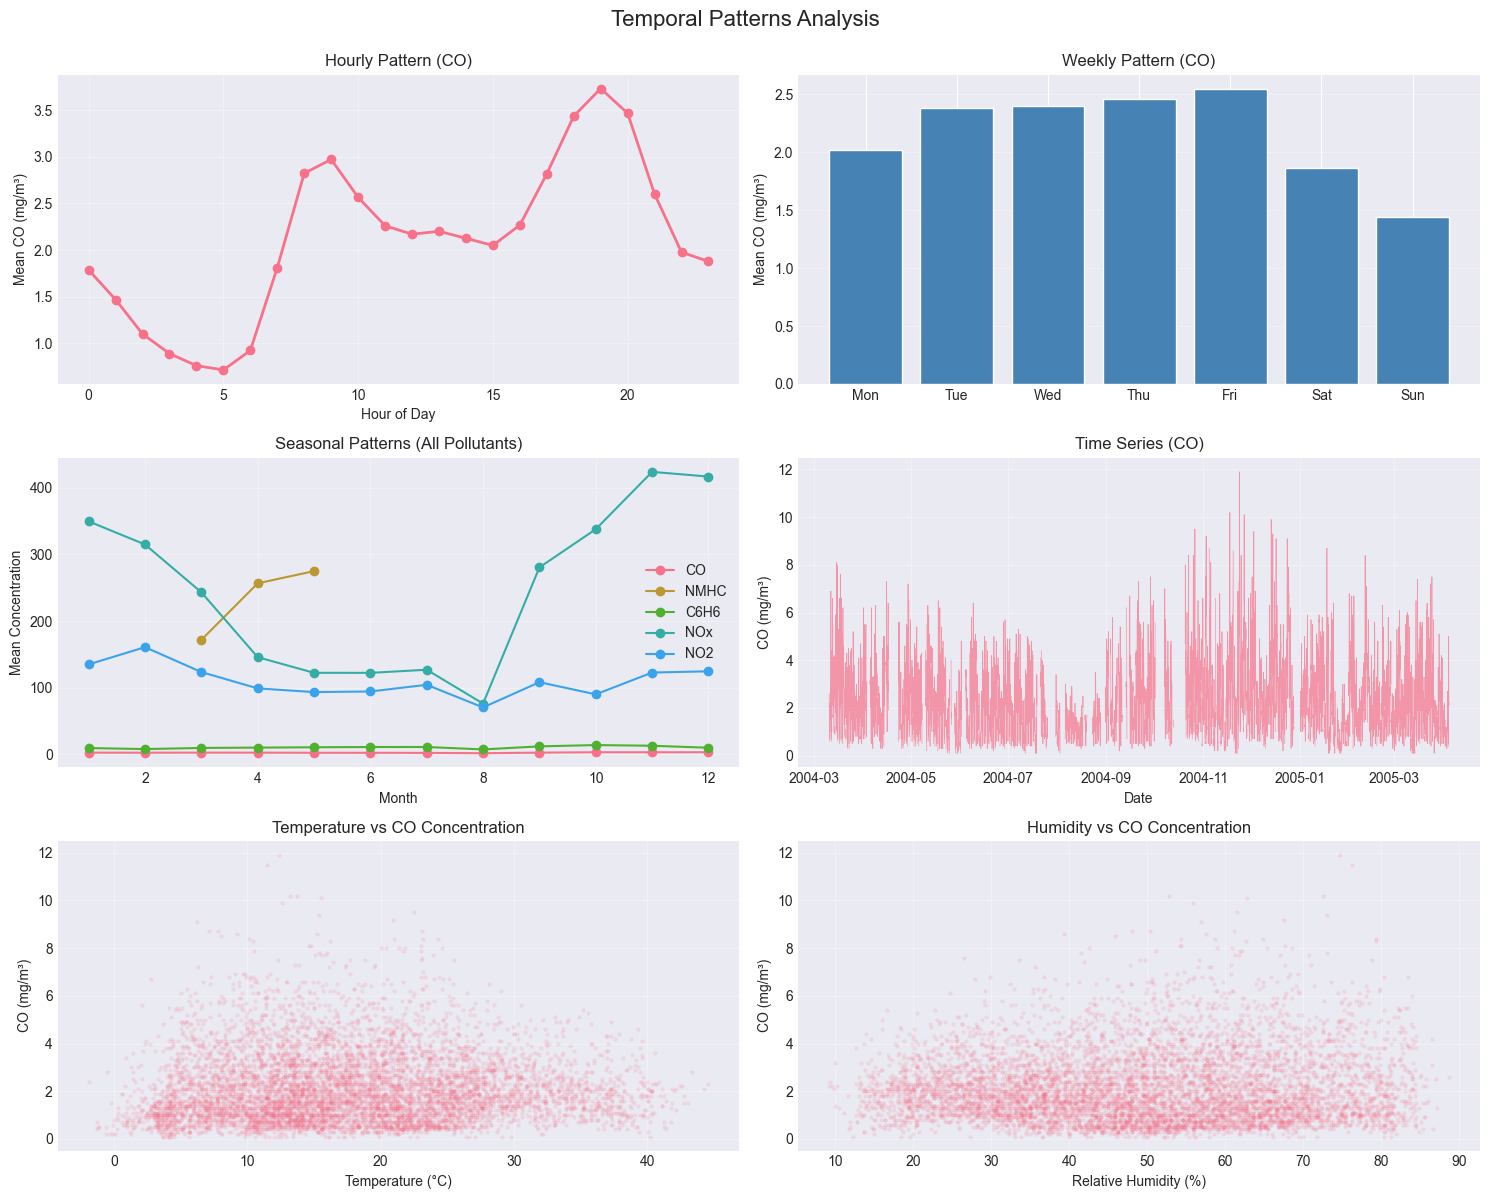

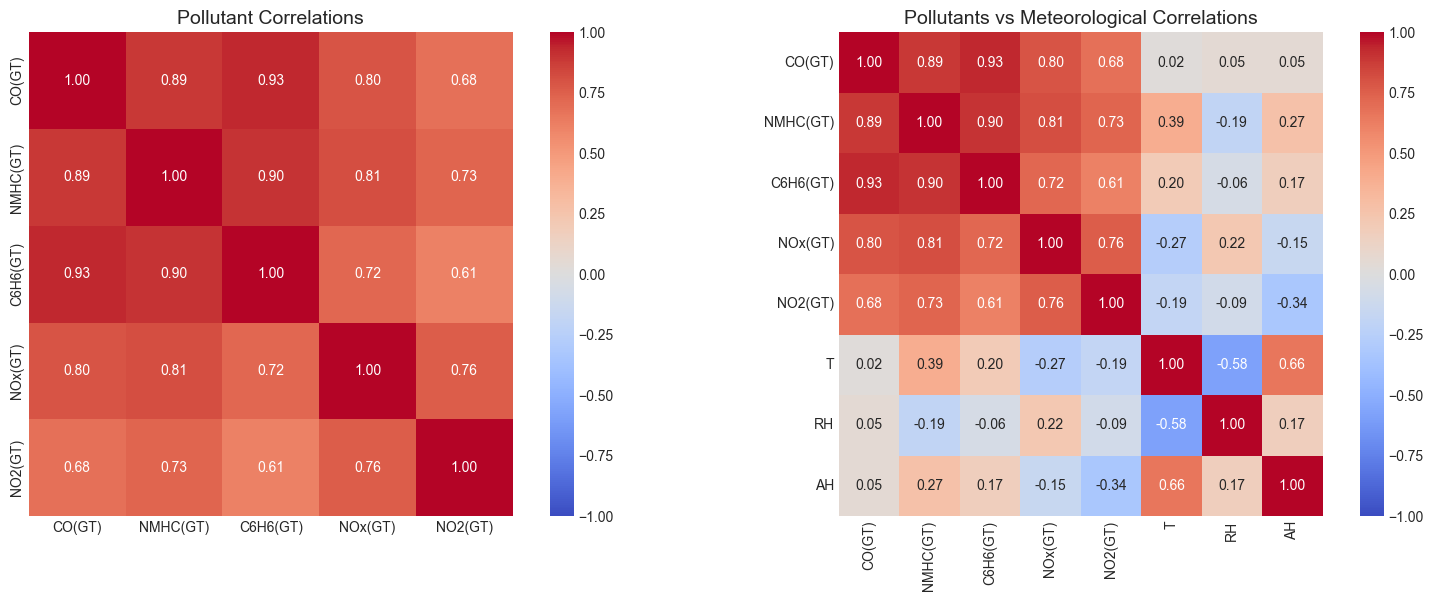

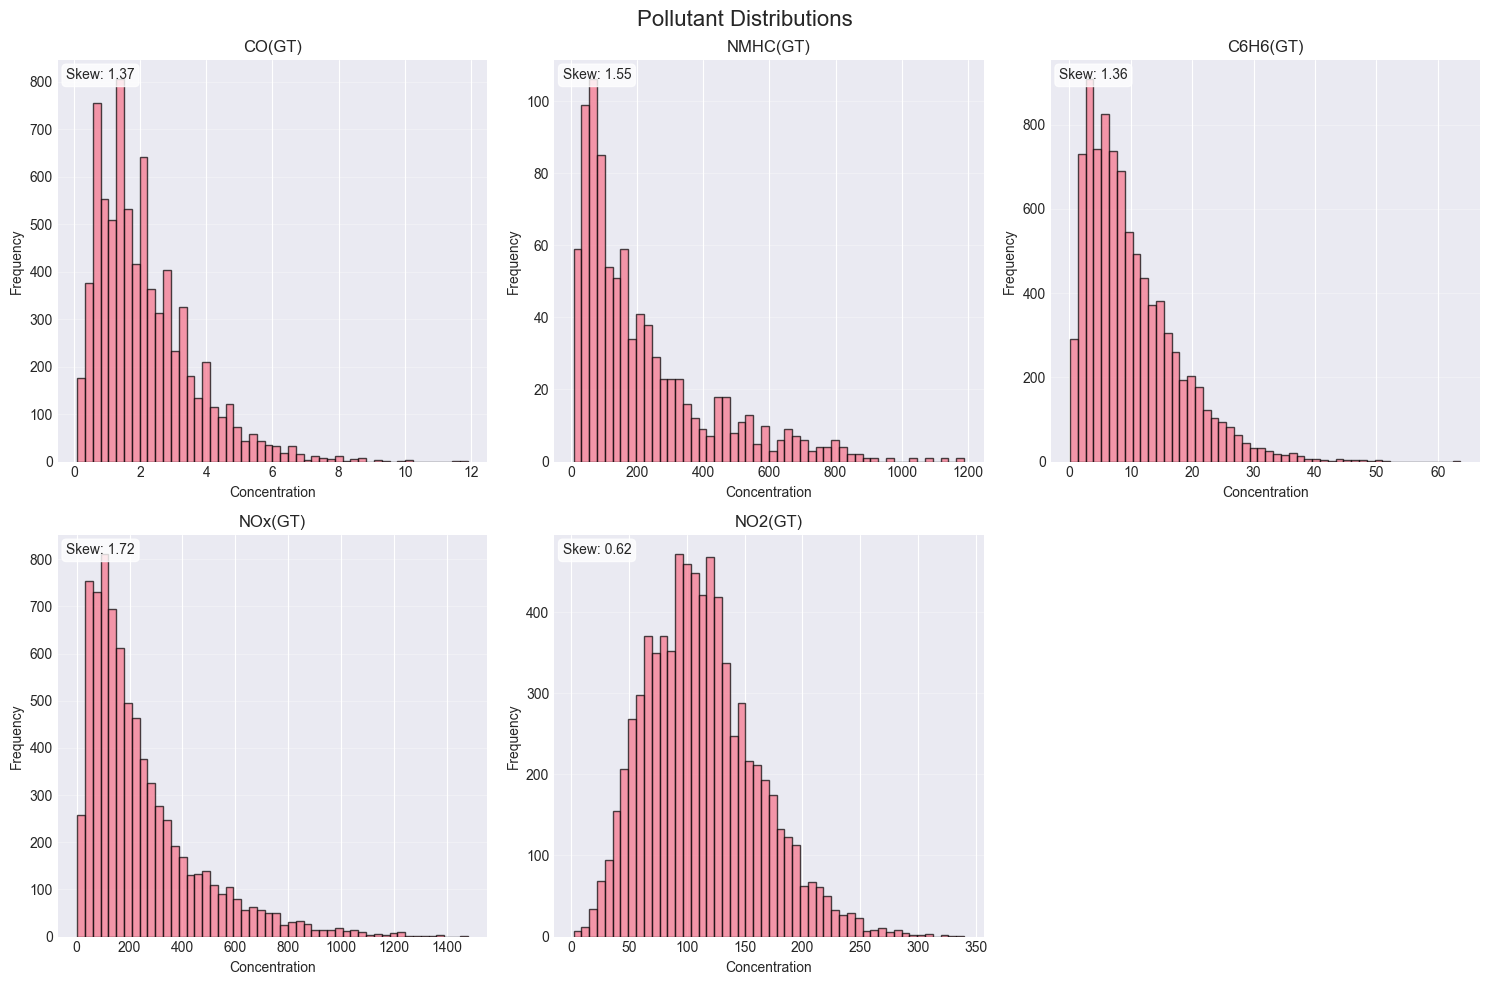

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory for figures
output_dir = 'eda_figures'
os.makedirs(output_dir, exist_ok=True)

# Load data
# Try XLSX first (cleaner), fallback to CSV
try:
    df = pd.read_excel('data/air+quality/AirQualityUCI.xlsx')
    print("Data source: AirQualityUCI.xlsx")
except:
    df = pd.read_csv('data/air+quality/AirQualityUCI.csv', sep=';', decimal=',')
    print("Data source: AirQualityUCI.csv")

# Remove unnamed/empty columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# ============================================
# 1. INITIAL DATA INSPECTION
# ============================================
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")

# ============================================
# 2. TEMPORAL PREPROCESSING
# ============================================
# Merge Date and Time into unified timestamp
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                 format='%d/%m/%Y %H.%M.%S',
                                 errors='coerce')
df = df.dropna(subset=['DateTime'])
df = df.set_index('DateTime').sort_index()
df = df.drop(['Date', 'Time'], axis=1)

# Extract temporal features
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year

print(f"\nTemporal range: {df.index.min()} to {df.index.max()}")
print(f"Duration: {(df.index.max() - df.index.min()).days} days")

# ============================================
# 3. MISSING VALUE ANALYSIS
# ============================================
# Replace sentinel value -200 with NaN
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col] = df[col].replace(-200.0, np.nan)

print("\n" + "="*60)
print("MISSING VALUE ANALYSIS")
print("="*60)
missing_summary = pd.DataFrame({
    'Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Count'] > 0].sort_values('Count', ascending=False)
print(missing_summary)

# ============================================
# 4. DESCRIPTIVE STATISTICS
# ============================================
pollutants = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo = ['T', 'RH', 'AH']

print("\n" + "="*60)
print("POLLUTANT STATISTICS")
print("="*60)
print(df[pollutants].describe().round(3))

# ============================================
# 5. TEMPORAL PATTERNS
# ============================================
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Temporal Patterns Analysis', fontsize=16, y=0.995)

# Hourly pattern
hourly_mean = df.groupby('Hour')['CO(GT)'].mean()
axes[0, 0].plot(hourly_mean.index, hourly_mean.values, marker='o', linewidth=2)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Mean CO (mg/m³)')
axes[0, 0].set_title('Hourly Pattern (CO)')
axes[0, 0].grid(True, alpha=0.3)

# Weekly pattern
weekly_mean = df.groupby('DayOfWeek')['CO(GT)'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), weekly_mean.values, color='steelblue')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(days)
axes[0, 1].set_ylabel('Mean CO (mg/m³)')
axes[0, 1].set_title('Weekly Pattern (CO)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Monthly pattern for all pollutants
for i, pollutant in enumerate(pollutants):
    monthly_mean = df.groupby('Month')[pollutant].mean()
    if i == 0:
        axes[1, 0].plot(monthly_mean.index, monthly_mean.values, marker='o', label=pollutant.split('(')[0])
    else:
        axes[1, 0].plot(monthly_mean.index, monthly_mean.values, marker='o', label=pollutant.split('(')[0])
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Mean Concentration')
axes[1, 0].set_title('Seasonal Patterns (All Pollutants)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Time series plot
axes[1, 1].plot(df.index, df['CO(GT)'], linewidth=0.5, alpha=0.7)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('CO (mg/m³)')
axes[1, 1].set_title('Time Series (CO)')
axes[1, 1].grid(True, alpha=0.3)

# Temperature vs CO
axes[2, 0].scatter(df['T'], df['CO(GT)'], alpha=0.1, s=5)
axes[2, 0].set_xlabel('Temperature (°C)')
axes[2, 0].set_ylabel('CO (mg/m³)')
axes[2, 0].set_title('Temperature vs CO Concentration')
axes[2, 0].grid(True, alpha=0.3)

# Humidity vs CO
axes[2, 1].scatter(df['RH'], df['CO(GT)'], alpha=0.1, s=5)
axes[2, 1].set_xlabel('Relative Humidity (%)')
axes[2, 1].set_ylabel('CO (mg/m³)')
axes[2, 1].set_title('Humidity vs CO Concentration')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'temporal_patterns.png'), dpi=300, bbox_inches='tight')
print(f"\n[SAVED] {output_dir}/temporal_patterns.png")

# ============================================
# 6. CORRELATION ANALYSIS
# ============================================
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Pollutant correlations
pollutant_corr = df[pollutants].corr()
print("\nPollutant Intercorrelations:")
print(pollutant_corr.round(3))

# Sensor vs Reference correlations
print("\nSensor-Reference Correlations:")
sensor_pairs = [
    ('PT08.S1(CO)', 'CO(GT)'),
    ('PT08.S2(NMHC)', 'NMHC(GT)'),
    ('PT08.S3(NOx)', 'NOx(GT)'),
    ('PT08.S4(NO2)', 'NO2(GT)')
]
for sensor, reference in sensor_pairs:
    corr = df[[sensor, reference]].corr().iloc[0, 1]
    print(f"{sensor} <-> {reference}: {corr:.3f}")

# Correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pollutants correlation
sns.heatmap(pollutant_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, ax=axes[0])
axes[0].set_title('Pollutant Correlations', fontsize=14)

# Full correlation (selected features)
selected_features = pollutants + meteo
full_corr = df[selected_features].corr()
sns.heatmap(full_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, ax=axes[1])
axes[1].set_title('Pollutants vs Meteorological Correlations', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
print(f"\n[SAVED] {output_dir}/correlation_heatmap.png")

# ============================================
# 7. DISTRIBUTION ANALYSIS
# ============================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Pollutant Distributions', fontsize=16)

for idx, pollutant in enumerate(pollutants):
    row = idx // 3
    col = idx % 3

    data = df[pollutant].dropna()
    axes[row, col].hist(data, bins=50, edgecolor='black', alpha=0.7)
    axes[row, col].set_xlabel('Concentration')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'{pollutant}')
    axes[row, col].grid(True, alpha=0.3, axis='y')

    # Add statistics
    skewness = stats.skew(data)
    axes[row, col].text(0.02, 0.98, f'Skew: {skewness:.2f}',
                       transform=axes[row, col].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pollutant_distributions.png'), dpi=300, bbox_inches='tight')
print(f"\n[SAVED] {output_dir}/pollutant_distributions.png")

# ============================================
# 8. DATA QUALITY SUMMARY
# ============================================
print("\n" + "="*60)
print("DATA QUALITY SUMMARY")
print("="*60)

# Outlier detection using IQR
print("\nOutliers (IQR method):")
for pollutant in pollutants:
    data = df[pollutant].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
    outlier_pct = (outliers / len(data) * 100)
    print(f"{pollutant}: {outliers} ({outlier_pct:.2f}%)")

# Weekday vs Weekend comparison
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
print("\n" + "="*60)
print("WEEKDAY VS WEEKEND COMPARISON (CO)")
print("="*60)
weekend_stats = df.groupby('IsWeekend')['CO(GT)'].agg(['mean', 'median', 'std'])
weekend_stats.index = ['Weekday', 'Weekend']
print(weekend_stats.round(3))

print("\n" + "="*60)
print("EDA COMPLETE")
print("="*60)
print(f"\nGenerated files in '{output_dir}/' directory:")
print("- temporal_patterns.png")
print("- correlation_heatmap.png")
print("- pollutant_distributions.png")

# Data Preprocessing

DATA PREPROCESSING PIPELINE

[STEP 1] Loading data...
✓ Loaded from AirQualityUCI.csv
  Original shape: (9357, 13)
  Date range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00

[STEP 2] Replacing sentinel value -200 with NaN...
  CO(GT): 1683 values replaced
  PT08.S1(CO): 366 values replaced
  NMHC(GT): 8443 values replaced
  C6H6(GT): 366 values replaced
  PT08.S2(NMHC): 366 values replaced
  NOx(GT): 1639 values replaced
  PT08.S3(NOx): 366 values replaced
  NO2(GT): 1642 values replaced
  PT08.S4(NO2): 366 values replaced
  PT08.S5(O3): 366 values replaced
  T: 366 values replaced
  RH: 366 values replaced
  AH: 366 values replaced

[STEP 3] Dropping NMHC(GT) (90.23% missing)...
✓ NMHC(GT) removed

[STEP 4] Handling missing values...
  Missing before: 8258
  Missing after interpolation: 1535
  Recovered: 6723 values
  Rows dropped (long gaps): 524
✓ Final shape: (8833, 12)

[STEP 5] Creating temporal features...
✓ Added temporal features: Hour, DayOfWeek, Month, Year, IsWeekend, etc.



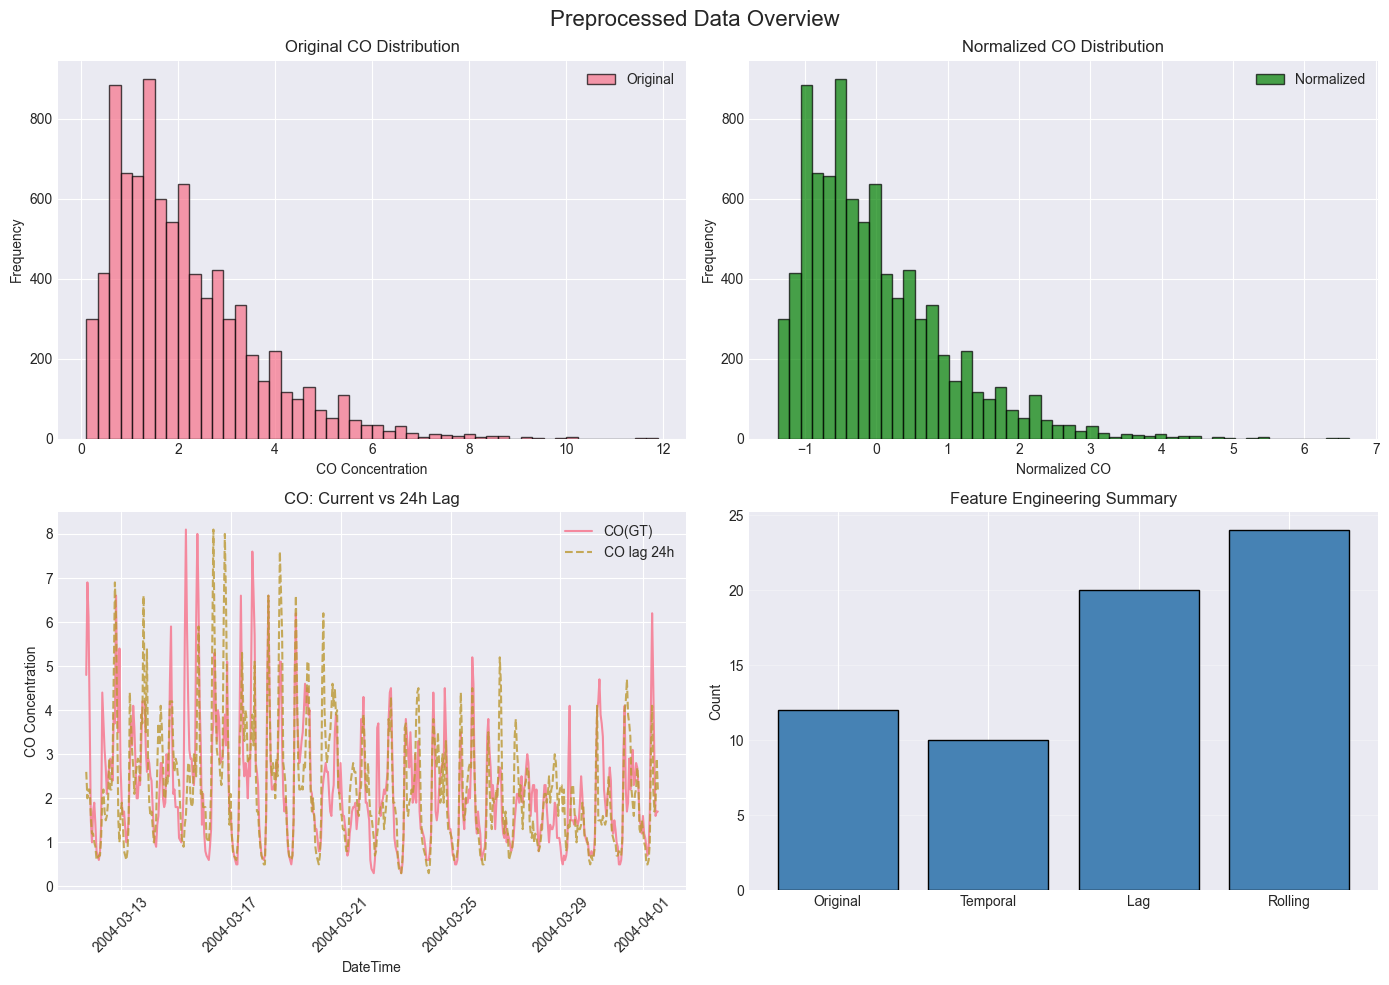

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
output_dir = 'preprocessing_output'
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("DATA PREPROCESSING PIPELINE")
print("="*70)

# ============================================
# 1. LOAD DATA
# ============================================
print("\n[STEP 1] Loading data...")
try:
    df = pd.read_excel('data/air+quality/AirQualityUCI.xlsx')
    print("✓ Loaded from AirQualityUCI.xlsx")
except:
    df = pd.read_csv('data/air+quality/AirQualityUCI.csv', sep=';', decimal=',')
    print("✓ Loaded from AirQualityUCI.csv")

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Merge temporal fields
if df['Date'].dtype == 'object':
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                     format='%d/%m/%Y %H.%M.%S', errors='coerce')
else:
    df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

df = df.dropna(subset=['DateTime'])
df = df.set_index('DateTime').sort_index()
df = df.drop(['Date', 'Time'], axis=1)

print(f"  Original shape: {df.shape}")
print(f"  Date range: {df.index.min()} to {df.index.max()}")

# ============================================
# 2. REPLACE SENTINEL VALUES
# ============================================
print("\n[STEP 2] Replacing sentinel value -200 with NaN...")
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    count = (df[col] == -200.0).sum()
    df[col] = df[col].replace(-200.0, np.nan)
    if count > 0:
        print(f"  {col}: {count} values replaced")

# ============================================
# 3. DROP NMHC(GT) - TOO MANY MISSING
# ============================================
print("\n[STEP 3] Dropping NMHC(GT) (90.23% missing)...")
if 'NMHC(GT)' in df.columns:
    df = df.drop('NMHC(GT)', axis=1)
    print("✓ NMHC(GT) removed")

# ============================================
# 4. HANDLE MISSING VALUES
# ============================================
print("\n[STEP 4] Handling missing values...")

pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo = ['T', 'RH', 'AH']
all_features = pollutants + sensors + meteo

before_missing = df[all_features].isnull().sum().sum()

# Strategy: Linear interpolation (≤6h) -> Forward fill (7-48h) -> Drop (>48h)
for col in all_features:
    # Linear interpolation for short gaps (limit 6 hours)
    df[col] = df[col].interpolate(method='linear', limit=6, limit_direction='both')

    # Forward fill for medium gaps (up to 48 hours)
    df[col] = df[col].fillna(method='ffill', limit=48)

after_interpolation = df[all_features].isnull().sum().sum()
print(f"  Missing before: {before_missing}")
print(f"  Missing after interpolation: {after_interpolation}")
print(f"  Recovered: {before_missing - after_interpolation} values")

# Drop rows with remaining long gaps (>48h)
rows_before = len(df)
df = df.dropna(subset=all_features)
rows_after = len(df)
print(f"  Rows dropped (long gaps): {rows_before - rows_after}")
print(f"✓ Final shape: {df.shape}")

# ============================================
# 5. EXTRACT TEMPORAL FEATURES
# ============================================
print("\n[STEP 5] Creating temporal features...")
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['DayOfYear'] = df.index.dayofyear

# Cyclical encoding for hour (24h cycle)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for month (12 month cycle)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

print(f"✓ Added temporal features: Hour, DayOfWeek, Month, Year, IsWeekend, etc.")

# ============================================
# 6. CREATE LAG FEATURES
# ============================================
print("\n[STEP 6] Creating lag features...")
lag_hours = [1, 3, 6, 12, 24]

for pollutant in pollutants:
    for lag in lag_hours:
        df[f'{pollutant.split("(")[0]}_lag{lag}h'] = df[pollutant].shift(lag)

print(f"✓ Created {len(pollutants) * len(lag_hours)} lag features")

# ============================================
# 7. CREATE ROLLING STATISTICS
# ============================================
print("\n[STEP 7] Creating rolling window features...")
windows = [6, 12, 24]

for pollutant in pollutants:
    for window in windows:
        # Rolling mean
        df[f'{pollutant.split("(")[0]}_rolling_mean_{window}h'] = \
            df[pollutant].rolling(window=window, min_periods=1).mean()

        # Rolling std
        df[f'{pollutant.split("(")[0]}_rolling_std_{window}h'] = \
            df[pollutant].rolling(window=window, min_periods=1).std()

print(f"✓ Created {len(pollutants) * len(windows) * 2} rolling features")

# ============================================
# 8. DROP ROWS WITH NAN FROM LAG FEATURES
# ============================================
print("\n[STEP 8] Handling NaN from lag/rolling features...")
rows_before = len(df)
df = df.dropna()
rows_after = len(df)
print(f"  Rows dropped: {rows_before - rows_after}")
print(f"✓ Clean shape: {df.shape}")

# ============================================
# 9. TEMPORAL SPLIT (2004 train, 2005 test) - BEFORE NORMALIZATION
# ============================================
print("\n[STEP 9] Creating temporal train/test split (before normalization)...")

# Split BEFORE normalization to avoid data leakage
train_df_raw = df[df['Year'] == 2004].copy()
test_df_raw = df[df['Year'] == 2005].copy()

print(f"  Train set (2004): {train_df_raw.shape}")
print(f"  Test set (2005): {test_df_raw.shape}")

# ============================================
# 10. NORMALIZE FEATURES (fit on train, transform both)
# ============================================
print("\n[STEP 10] Normalizing continuous features (fit on train only)...")

# Features to normalize (exclude temporal indicators)
features_to_normalize = (pollutants + sensors + meteo +
                         [col for col in df.columns if 'lag' in col or 'rolling' in col])

# Fit scaler ONLY on training data to avoid data leakage
scaler = StandardScaler()
scaler.fit(train_df_raw[features_to_normalize])

# Transform both train and test using the scaler fitted on train data
train_df = train_df_raw.copy()
test_df = test_df_raw.copy()

train_df[features_to_normalize] = scaler.transform(train_df_raw[features_to_normalize])
test_df[features_to_normalize] = scaler.transform(test_df_raw[features_to_normalize])

print(f"✓ Normalized {len(features_to_normalize)} features")
print(f"  Scaler fitted on: {len(train_df_raw)} training samples")
print(f"  Train set normalized: {train_df.shape}")
print(f"  Test set normalized: {test_df.shape}")

# ============================================
# 11. SAVE PREPROCESSED DATA
# ============================================
print("\n[STEP 11] Saving preprocessed data...")

# Save full preprocessed data (unnormalized)
df.to_csv(os.path.join(output_dir, 'preprocessed_data_full.csv'))
print(f"✓ Saved: {output_dir}/preprocessed_data_full.csv")

# Combine train and test for saving normalized data (for reference)
df_normalized = pd.concat([train_df, test_df]).sort_index()
df_normalized.to_csv(os.path.join(output_dir, 'preprocessed_data_normalized.csv'))
print(f"✓ Saved: {output_dir}/preprocessed_data_normalized.csv")

# Save train/test splits
train_df.to_csv(os.path.join(output_dir, 'train_2004.csv'))
test_df.to_csv(os.path.join(output_dir, 'test_2005.csv'))
print(f"✓ Saved: {output_dir}/train_2004.csv")
print(f"✓ Saved: {output_dir}/test_2005.csv")

# Save scaler
import joblib
joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))
print(f"✓ Saved: {output_dir}/scaler.pkl")

# ============================================
# 12. SUMMARY STATISTICS
# ============================================
print("\n" + "="*70)
print("PREPROCESSING SUMMARY")
print("="*70)

print(f"\nFinal dataset:")
print(f"  Total samples: {len(df)}")
print(f"  Total features: {len(df.columns)}")
print(f"  Original features: {len(pollutants + sensors + meteo)}")
print(f"  Temporal features: {len([c for c in df.columns if any(x in c for x in ['Hour', 'Day', 'Month', 'Year', 'Weekend'])])}")
print(f"  Lag features: {len([c for c in df.columns if 'lag' in c])}")
print(f"  Rolling features: {len([c for c in df.columns if 'rolling' in c])}")

print(f"\nTrain/Test split:")
print(f"  Train samples: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Test samples: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nTarget variables (pollutants):")
for pol in pollutants:
    print(f"  {pol}: min={df[pol].min():.2f}, max={df[pol].max():.2f}, mean={df[pol].mean():.2f}")

# ============================================
# 13. VISUALIZATION
# ============================================
print("\n[STEP 12] Creating visualization...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Preprocessed Data Overview', fontsize=16)

# Original vs normalized CO
axes[0, 0].hist(df['CO(GT)'], bins=50, alpha=0.7, label='Original', edgecolor='black')
axes[0, 0].set_xlabel('CO Concentration')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Original CO Distribution')
axes[0, 0].legend()

axes[0, 1].hist(df_normalized['CO(GT)'], bins=50, alpha=0.7,
                label='Normalized', color='green', edgecolor='black')
axes[0, 1].set_xlabel('Normalized CO')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Normalized CO Distribution')
axes[0, 1].legend()

# Time series with lag feature
sample_size = 500
sample_df = df.iloc[:sample_size]
axes[1, 0].plot(sample_df.index, sample_df['CO(GT)'],
                label='CO(GT)', linewidth=1.5, alpha=0.8)
axes[1, 0].plot(sample_df.index, sample_df['CO_lag24h'],
                label='CO lag 24h', linewidth=1.5, alpha=0.8, linestyle='--')
axes[1, 0].set_xlabel('DateTime')
axes[1, 0].set_ylabel('CO Concentration')
axes[1, 0].set_title('CO: Current vs 24h Lag')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Feature count by type
feature_types = {
    'Original': len(pollutants + sensors + meteo),
    'Temporal': len([c for c in df.columns if any(x in c for x in ['Hour', 'Day', 'Month', 'Year', 'Weekend'])]),
    'Lag': len([c for c in df.columns if 'lag' in c]),
    'Rolling': len([c for c in df.columns if 'rolling' in c])
}
axes[1, 1].bar(feature_types.keys(), feature_types.values(), color='steelblue', edgecolor='black')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Feature Engineering Summary')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'preprocessing_summary.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_dir}/preprocessing_summary.png")

print("\n" + "="*70)
print("PREPROCESSING COMPLETE")
print("="*70)
print(f"\nAll outputs saved to '{output_dir}/' directory")
print("\nNext steps:")
print("  1. Load train_2004.csv for model training")
print("  2. Load test_2005.csv for evaluation")
print("  3. Use scaler.pkl for new data normalization")

# Feature Engineering

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Configuration
output_dir = 'temporal_feature_engineering'
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("MULTI-GRANULARITY FEATURE ENGINEERING & TEMPORAL SPLITTING")
print("="*70)

# ============================================
# 1. LOAD PREPROCESSED DATA
# ============================================
print("\n[STEP 1] Loading preprocessed data...")

# Load the preprocessed data
df = pd.read_csv('preprocessing_output/preprocessed_data_full.csv', index_col='DateTime', parse_dates=True)

print(f"✓ Loaded preprocessed data shape: {df.shape}")
print(f"✓ Date range: {df.index.min()} to {df.index.max()}")

# Define feature groups
pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo = ['T', 'RH', 'AH']

print(f"✓ Features: {len(pollutants)} pollutants, {len(sensors)} sensors, {len(meteo)} meteo")

# ============================================
# 2. CREATE HOURLY FEATURES (FINE-GRAINED)
# ============================================
print("\n[STEP 2] Creating hourly features...")

# Basic temporal features
df_hourly = df.copy()
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day_of_week'] = df_hourly.index.dayofweek
df_hourly['month'] = df_hourly.index.month
df_hourly['is_weekend'] = (df_hourly['day_of_week'] >= 5).astype(int)

# Cyclical encoding
def encode_cyclical(df, col, max_val):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

df_hourly = encode_cyclical(df_hourly, 'hour', 24)
df_hourly = encode_cyclical(df_hourly, 'day_of_week', 7)

# Short-term lagged features (1-12 hours)
print("  Creating short-term lagged features...")
for pollutant in pollutants:
    for lag in [1, 3, 6, 12]:  # 1h, 3h, 6h, 12h
        df_hourly[f'{pollutant}_lag_{lag}h'] = df_hourly[pollutant].shift(lag)

# Short-term moving averages (4-12 hours)
print("  Creating short-term moving averages...")
for pollutant in pollutants:
    for window in [4, 8, 12]:  # 4h, 8h, 12h
        df_hourly[f'{pollutant}_ma_{window}h'] = df_hourly[pollutant].rolling(window=window, min_periods=1).mean()

# Rate of change features
print("  Creating rate of change features...")
for pollutant in pollutants:
    df_hourly[f'{pollutant}_hourly_change'] = df_hourly[pollutant].diff()
    df_hourly[f'{pollutant}_hourly_pct_change'] = df_hourly[pollutant].pct_change()

# Remove rows with NaN from lag features
df_hourly_clean = df_hourly.dropna()
print(f"✓ Hourly features shape: {df_hourly_clean.shape}")

# ============================================
# 3. CREATE DAILY FEATURES (COARSE-GRAINED)
# ============================================
print("\n[STEP 3] Creating daily features...")

# Create daily aggregates
daily_agg_dict = {}
for pollutant in pollutants:
    daily_agg_dict[pollutant] = ['mean', 'max', 'std']
for sensor in sensors:
    daily_agg_dict[sensor] = ['mean', 'max']
for meteo_var in meteo:
    daily_agg_dict[meteo_var] = ['mean', 'max']

df_daily = df.resample('D').agg(daily_agg_dict)
df_daily.columns = ['_'.join(col).strip() for col in df_daily.columns.values]

# Add daily temporal features
df_daily['day_of_week'] = df_daily.index.dayofweek
df_daily['month'] = df_daily.index.month
df_daily['is_weekend'] = (df_daily['day_of_week'] >= 5).astype(int)

# Daily lag features
print("  Creating daily lagged features...")
for col in ['CO(GT)_mean', 'C6H6(GT)_mean', 'NOx(GT)_mean', 'NO2(GT)_mean']:
    for lag in [1, 2, 7]:  # 1 day, 2 days, 1 week
        df_daily[f'{col}_lag_{lag}d'] = df_daily[col].shift(lag)

df_daily_clean = df_daily.dropna()
print(f"✓ Daily features shape: {df_daily_clean.shape}")

# ============================================
# 4. CREATE FULL FEATURES (HOURLY + DAILY MERGED)
# ============================================
print("\n[STEP 4] Creating full features (hourly + daily merged)...")

# Prepare daily data for merging (ensure proper datetime index)
daily_for_merge = df_daily_clean.copy()
daily_for_merge.index = pd.to_datetime(daily_for_merge.index)

# Add date column to hourly data for merging
df_full = df_hourly_clean.copy()
df_full['merge_date'] = df_full.index.normalize()

# Select daily features to merge (avoid duplicate temporal features)
daily_features_to_merge = [col for col in daily_for_merge.columns 
                          if not col in ['day_of_week', 'month', 'is_weekend']]

# Merge daily features into hourly data
df_full = df_full.merge(
    daily_for_merge[daily_features_to_merge], 
    left_on='merge_date', 
    right_index=True, 
    how='left',
    suffixes=('', '_daily')
)

# Remove temporary column
df_full = df_full.drop('merge_date', axis=1)
df_full_clean = df_full.dropna()

print(f"✓ Full features shape: {df_full_clean.shape}")
print(f"✓ Added {len(daily_features_to_merge)} daily features to hourly data")

# ============================================
# 5. TEMPORAL DATA SPLITTING (3 VERSIONS)
# ============================================
print("\n[STEP 5] Creating temporal splits for all three versions...")

def create_temporal_splits(df, target_cols, features_exclude):
    """创建时序分割的训练集、验证集、测试集"""
    # 定义特征和目标
    X = df.drop(features_exclude, axis=1)
    y = df[target_cols] if isinstance(target_cols, list) else df[[target_cols]]
    
    # 按年份分割 (2004训练, 2005测试)
    train_mask = df.index.year == 2004
    test_mask = df.index.year == 2005
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    
    # 从训练集创建验证集 (后20%)
    split_point = int(0.8 * len(X_train))
    X_train_final = X_train.iloc[:split_point]
    X_val = X_train.iloc[split_point:]
    y_train_final = y_train.iloc[:split_point]
    y_val = y_train.iloc[split_point:]
    
    return X_train_final, X_val, X_test, y_train_final, y_val, y_test

# HOURLY VERSION
print("  Creating hourly version splits...")
features_exclude_hourly = pollutants + [col for col in df_hourly_clean.columns if 'time_of_day' in col]
X_train_h, X_val_h, X_test_h, y_train_h, y_val_h, y_test_h = create_temporal_splits(
    df_hourly_clean, pollutants, features_exclude_hourly
)

# DAILY VERSION  
print("  Creating daily version splits...")
# For daily, use CO mean as target example
target_daily = 'CO(GT)_mean'
features_exclude_daily = [col for col in df_daily_clean.columns 
                         if any(pollutant in col for pollutant in pollutants)]
X_train_d, X_val_d, X_test_d, y_train_d, y_val_d, y_test_d = create_temporal_splits(
    df_daily_clean, target_daily, features_exclude_daily
)

# FULL VERSION
print("  Creating full version splits...")
features_exclude_full = pollutants + [col for col in df_full_clean.columns if 'time_of_day' in col]
X_train_f, X_val_f, X_test_f, y_train_f, y_val_f, y_test_f = create_temporal_splits(
    df_full_clean, pollutants, features_exclude_full
)

print("✓ Temporal splits completed:")
print(f"  Hourly - Train: {X_train_h.shape}, Val: {X_val_h.shape}, Test: {X_test_h.shape}")
print(f"  Daily  - Train: {X_train_d.shape}, Val: {X_val_d.shape}, Test: {X_test_d.shape}")
print(f"  Full   - Train: {X_train_f.shape}, Val: {X_val_f.shape}, Test: {X_test_f.shape}")

# ============================================
# 6. FEATURE ANALYSIS & SUMMARY
# ============================================
print("\n[STEP 6] Analyzing feature sets...")

# Feature counts by category
hourly_feature_count = X_train_h.shape[1]
daily_feature_count = X_train_d.shape[1]
full_feature_count = X_train_f.shape[1]

print("\n📊 FEATURE SETS SUMMARY:")
print("="*50)
print(f"🏠 HOURLY FEATURES (Fine-grained):")
print(f"   • Total features: {hourly_feature_count}")
print(f"   • Training samples: {X_train_h.shape[0]}")
print(f"   • Validation samples: {X_val_h.shape[0]}")
print(f"   • Test samples: {X_test_h.shape[0]}")
print(f"   • Includes: Short-term lags, hourly patterns")

print(f"\n📅 DAILY FEATURES (Coarse-grained):")
print(f"   • Total features: {daily_feature_count}")
print(f"   • Training samples: {X_train_d.shape[0]}")
print(f"   • Validation samples: {X_val_d.shape[0]}")
print(f"   • Test samples: {X_test_d.shape[0]}")
print(f"   • Includes: Daily aggregates, seasonal patterns")

print(f"\n🔥 FULL FEATURES (Hourly + Daily):")
print(f"   • Total features: {full_feature_count}")
print(f"   • Training samples: {X_train_f.shape[0]}")
print(f"   • Validation samples: {X_val_f.shape[0]}")
print(f"   • Test samples: {X_test_f.shape[0]}")
print(f"   • Includes: Both fine and coarse temporal patterns")

# ============================================
# 7. SAVE ALL DATASETS
# ============================================
print("\n[STEP 7] Saving all datasets...")

# Save full feature datasets
df_hourly_clean.to_csv(os.path.join(output_dir, 'features_hourly_full.csv'))
df_daily_clean.to_csv(os.path.join(output_dir, 'features_daily_full.csv'))
df_full_clean.to_csv(os.path.join(output_dir, 'features_full_merged.csv'))
print("✓ Saved full feature datasets")

# Save hourly version
pd.concat([X_train_h, y_train_h], axis=1).to_csv(os.path.join(output_dir, 'train_hourly.csv'))
pd.concat([X_val_h, y_val_h], axis=1).to_csv(os.path.join(output_dir, 'val_hourly.csv'))
pd.concat([X_test_h, y_test_h], axis=1).to_csv(os.path.join(output_dir, 'test_hourly.csv'))
print("✓ Saved hourly version splits")

# Save daily version
pd.concat([X_train_d, y_train_d], axis=1).to_csv(os.path.join(output_dir, 'train_daily.csv'))
pd.concat([X_val_d, y_val_d], axis=1).to_csv(os.path.join(output_dir, 'val_daily.csv'))
pd.concat([X_test_d, y_test_d], axis=1).to_csv(os.path.join(output_dir, 'test_daily.csv'))
print("✓ Saved daily version splits")

# Save full version
pd.concat([X_train_f, y_train_f], axis=1).to_csv(os.path.join(output_dir, 'train_full.csv'))
pd.concat([X_val_f, y_val_f], axis=1).to_csv(os.path.join(output_dir, 'val_full.csv'))
pd.concat([X_test_f, y_test_f], axis=1).to_csv(os.path.join(output_dir, 'test_full.csv'))
print("✓ Saved full version splits")

# Save separate X and y files for modeling
datasets = {
    'hourly': (X_train_h, X_val_h, X_test_h, y_train_h, y_val_h, y_test_h),
    'daily': (X_train_d, X_val_d, X_test_d, y_train_d, y_val_d, y_test_d),
    'full': (X_train_f, X_val_f, X_test_f, y_train_f, y_val_f, y_test_f)
}

for version, (X_train, X_val, X_test, y_train, y_val, y_test) in datasets.items():
    X_train.to_csv(os.path.join(output_dir, f'X_train_{version}.csv'))
    X_val.to_csv(os.path.join(output_dir, f'X_val_{version}.csv'))
    X_test.to_csv(os.path.join(output_dir, f'X_test_{version}.csv'))
    y_train.to_csv(os.path.join(output_dir, f'y_train_{version}.csv'))
    y_val.to_csv(os.path.join(output_dir, f'y_val_{version}.csv'))
    y_test.to_csv(os.path.join(output_dir, f'y_test_{version}.csv'))

print("✓ Saved separate X/y files for modeling")

# Save dataset summary
summary = pd.DataFrame({
    'version': ['hourly', 'daily', 'full'],
    'features': [hourly_feature_count, daily_feature_count, full_feature_count],
    'train_samples': [X_train_h.shape[0], X_train_d.shape[0], X_train_f.shape[0]],
    'val_samples': [X_val_h.shape[0], X_val_d.shape[0], X_val_f.shape[0]],
    'test_samples': [X_test_h.shape[0], X_test_d.shape[0], X_test_f.shape[0]],
    'train_period': [
        f"{X_train_h.index.min().date()} to {X_train_h.index.max().date()}",
        f"{X_train_d.index.min().date()} to {X_train_d.index.max().date()}",
        f"{X_train_f.index.min().date()} to {X_train_f.index.max().date()}"
    ],
    'test_period': [
        f"{X_test_h.index.min().date()} to {X_test_h.index.max().date()}",
        f"{X_test_d.index.min().date()} to {X_test_d.index.max().date()}",
        f"{X_test_f.index.min().date()} to {X_test_f.index.max().date()}"
    ]
})
summary.to_csv(os.path.join(output_dir, 'dataset_summary.csv'), index=False)
print("✓ Saved dataset summary")

print("\n" + "="*70)
print("MULTI-GRANULARITY FEATURE ENGINEERING COMPLETE!")
print("="*70)

print(f"\n🎯 THREE DATASET VERSIONS CREATED:")
print(f"   1. HOURLY - {hourly_feature_count} features (fine-grained)")
print(f"   2. DAILY  - {daily_feature_count} features (coarse-grained)") 
print(f"   3. FULL   - {full_feature_count} features (combined)")
print(f"\n💾 All files saved to: {output_dir}/")
print(f"\n📁 Files created:")
print(f"   • train/val/test_hourly.csv")
print(f"   • train/val/test_daily.csv") 
print(f"   • train/val/test_full.csv")
print(f"   • X/y_train/val/test_{version}.csv")
print(f"   • features_*_full.csv")
print(f"   • dataset_summary.csv")

MULTI-GRANULARITY FEATURE ENGINEERING & TEMPORAL SPLITTING

[STEP 1] Loading preprocessed data...
✓ Loaded preprocessed data shape: (8809, 66)
✓ Date range: 2004-03-11 18:00:00 to 2005-04-04 14:00:00
✓ Features: 4 pollutants, 5 sensors, 3 meteo

[STEP 2] Creating hourly features...
  Creating short-term lagged features...
  Creating short-term moving averages...
  Creating rate of change features...
✓ Hourly features shape: (8797, 110)

[STEP 3] Creating daily features...
  Creating daily lagged features...
✓ Daily features shape: (349, 43)

[STEP 4] Creating full features (hourly + daily merged)...
✓ Full features shape: (8213, 150)
✓ Added 40 daily features to hourly data

[STEP 5] Creating temporal splits for all three versions...
  Creating hourly version splits...
  Creating daily version splits...
  Creating full version splits...
✓ Temporal splits completed:
  Hourly - Train: (5252, 106), Val: (1314, 106), Test: (2231, 106)
  Daily  - Train: (204, 19), Val: (51, 19), Test: (94, 

In [15]:
X_train_f.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,DayOfWeek,...,CO(GT)_mean_lag_7d,C6H6(GT)_mean_lag_1d,C6H6(GT)_mean_lag_2d,C6H6(GT)_mean_lag_7d,NOx(GT)_mean_lag_1d,NOx(GT)_mean_lag_2d,NOx(GT)_mean_lag_7d,NO2(GT)_mean_lag_1d,NO2(GT)_mean_lag_2d,NO2(GT)_mean_lag_7d
DateTime,,,,,,,,,,,,,,,,,,,,,
2004-03-18 00:00:00,1371.0,1083.0,796.0,1669.0,1551.0,14.8,53.9,0.9024,0,3,...,4.033333,15.2375,13.5,15.383333,194.208333,176.166667,232.666667,117.854167,115.75,127.0
2004-03-18 01:00:00,1161.0,904.0,947.0,1502.0,1240.0,14.3,55.4,0.8975,1,3,...,4.033333,15.2375,13.5,15.383333,194.208333,176.166667,232.666667,117.854167,115.75,127.0
2004-03-18 02:00:00,1064.0,787.0,1057.0,1407.0,1115.0,14.8,52.1,0.8686,2,3,...,4.033333,15.2375,13.5,15.383333,194.208333,176.166667,232.666667,117.854167,115.75,127.0
2004-03-18 03:00:00,970.0,687.0,1196.0,1351.0,969.0,13.9,53.9,0.8501,3,3,...,4.033333,15.2375,13.5,15.383333,194.208333,176.166667,232.666667,117.854167,115.75,127.0
2004-03-18 04:00:00,954.0,645.0,1260.0,1334.0,925.0,11.6,61.9,0.8442,4,3,...,4.033333,15.2375,13.5,15.383333,194.208333,176.166667,232.666667,117.854167,115.75,127.0


In [16]:
X_val_f.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,DayOfWeek,...,CO(GT)_mean_lag_7d,C6H6(GT)_mean_lag_1d,C6H6(GT)_mean_lag_2d,C6H6(GT)_mean_lag_7d,NOx(GT)_mean_lag_1d,NOx(GT)_mean_lag_2d,NOx(GT)_mean_lag_7d,NO2(GT)_mean_lag_1d,NO2(GT)_mean_lag_2d,NO2(GT)_mean_lag_7d
DateTime,,,,,,,,,,,,,,,,,,,,,
2004-11-10 00:00:00,831.0,620.0,1164.0,1039.0,545.0,6.5,83.5,0.8116,0,2,...,2.475,10.375,8.441667,13.691667,577.551471,322.698529,301.9375,147.330882,106.814951,80.229167
2004-11-10 01:00:00,843.0,622.0,1146.0,1060.0,555.0,6.9,82.3,0.8244,1,2,...,2.475,10.375,8.441667,13.691667,577.551471,322.698529,301.9375,147.330882,106.814951,80.229167
2004-11-10 02:00:00,798.0,600.0,1151.0,1049.0,543.0,7.3,78.1,0.8041,2,2,...,2.475,10.375,8.441667,13.691667,577.551471,322.698529,301.9375,147.330882,106.814951,80.229167
2004-11-10 03:00:00,730.0,477.0,1433.0,950.0,420.0,7.9,68.0,0.7265,3,2,...,2.475,10.375,8.441667,13.691667,577.551471,322.698529,301.9375,147.330882,106.814951,80.229167
2004-11-10 04:00:00,715.0,445.0,1601.0,925.0,373.0,8.0,64.5,0.6950,4,2,...,2.475,10.375,8.441667,13.691667,577.551471,322.698529,301.9375,147.330882,106.814951,80.229167


In [17]:
X_test_f.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,DayOfWeek,...,CO(GT)_mean_lag_7d,C6H6(GT)_mean_lag_1d,C6H6(GT)_mean_lag_2d,C6H6(GT)_mean_lag_7d,NOx(GT)_mean_lag_1d,NOx(GT)_mean_lag_2d,NOx(GT)_mean_lag_7d,NO2(GT)_mean_lag_1d,NO2(GT)_mean_lag_2d,NO2(GT)_mean_lag_7d
DateTime,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:00:00,1046.0,724.0,848.0,898.0,1201.0,8.2,40.1,0.4375,0,5,...,3.9125,5.26,1.571429,13.104167,212.938144,168.092784,444.166667,105.793814,101.309278,147.375
2005-01-01 01:00:00,1275.0,930.0,649.0,1024.0,1617.0,5.3,50.7,0.4564,1,5,...,3.9125,5.26,1.571429,13.104167,212.938144,168.092784,444.166667,105.793814,101.309278,147.375
2005-01-01 02:00:00,1173.0,878.0,738.0,1002.0,1355.0,5.9,50.0,0.4689,2,5,...,3.9125,5.26,1.571429,13.104167,212.938144,168.092784,444.166667,105.793814,101.309278,147.375
2005-01-01 03:00:00,1163.0,881.0,748.0,1001.0,1296.0,4.9,53.9,0.4693,3,5,...,3.9125,5.26,1.571429,13.104167,212.938144,168.092784,444.166667,105.793814,101.309278,147.375
2005-01-01 04:00:00,1054.0,791.0,830.0,967.0,1131.0,4.3,55.3,0.4650,4,5,...,3.9125,5.26,1.571429,13.104167,212.938144,168.092784,444.166667,105.793814,101.309278,147.375


# Anomaly and Event Detection:

ANOMALY DETECTION ANALYSIS (train_2004.csv ONLY)

[STEP 1] Loading train_2004.csv data...
✓ Data shape: (6578, 66)
✓ Columns: ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Hour', 'DayOfWeek', 'Month', 'Year', 'IsWeekend', 'DayOfYear', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'CO_lag1h', 'CO_lag3h', 'CO_lag6h', 'CO_lag12h', 'CO_lag24h', 'C6H6_lag1h', 'C6H6_lag3h', 'C6H6_lag6h', 'C6H6_lag12h', 'C6H6_lag24h', 'NOx_lag1h', 'NOx_lag3h', 'NOx_lag6h', 'NOx_lag12h', 'NOx_lag24h', 'NO2_lag1h', 'NO2_lag3h', 'NO2_lag6h', 'NO2_lag12h', 'NO2_lag24h', 'CO_rolling_mean_6h', 'CO_rolling_std_6h', 'CO_rolling_mean_12h', 'CO_rolling_std_12h', 'CO_rolling_mean_24h', 'CO_rolling_std_24h', 'C6H6_rolling_mean_6h', 'C6H6_rolling_std_6h', 'C6H6_rolling_mean_12h', 'C6H6_rolling_std_12h', 'C6H6_rolling_mean_24h', 'C6H6_rolling_std_24h', 'NOx_rolling_mean_6h', 'NOx_rolling_std_6h', 'NOx_rolling_mean_12h', 'NOx

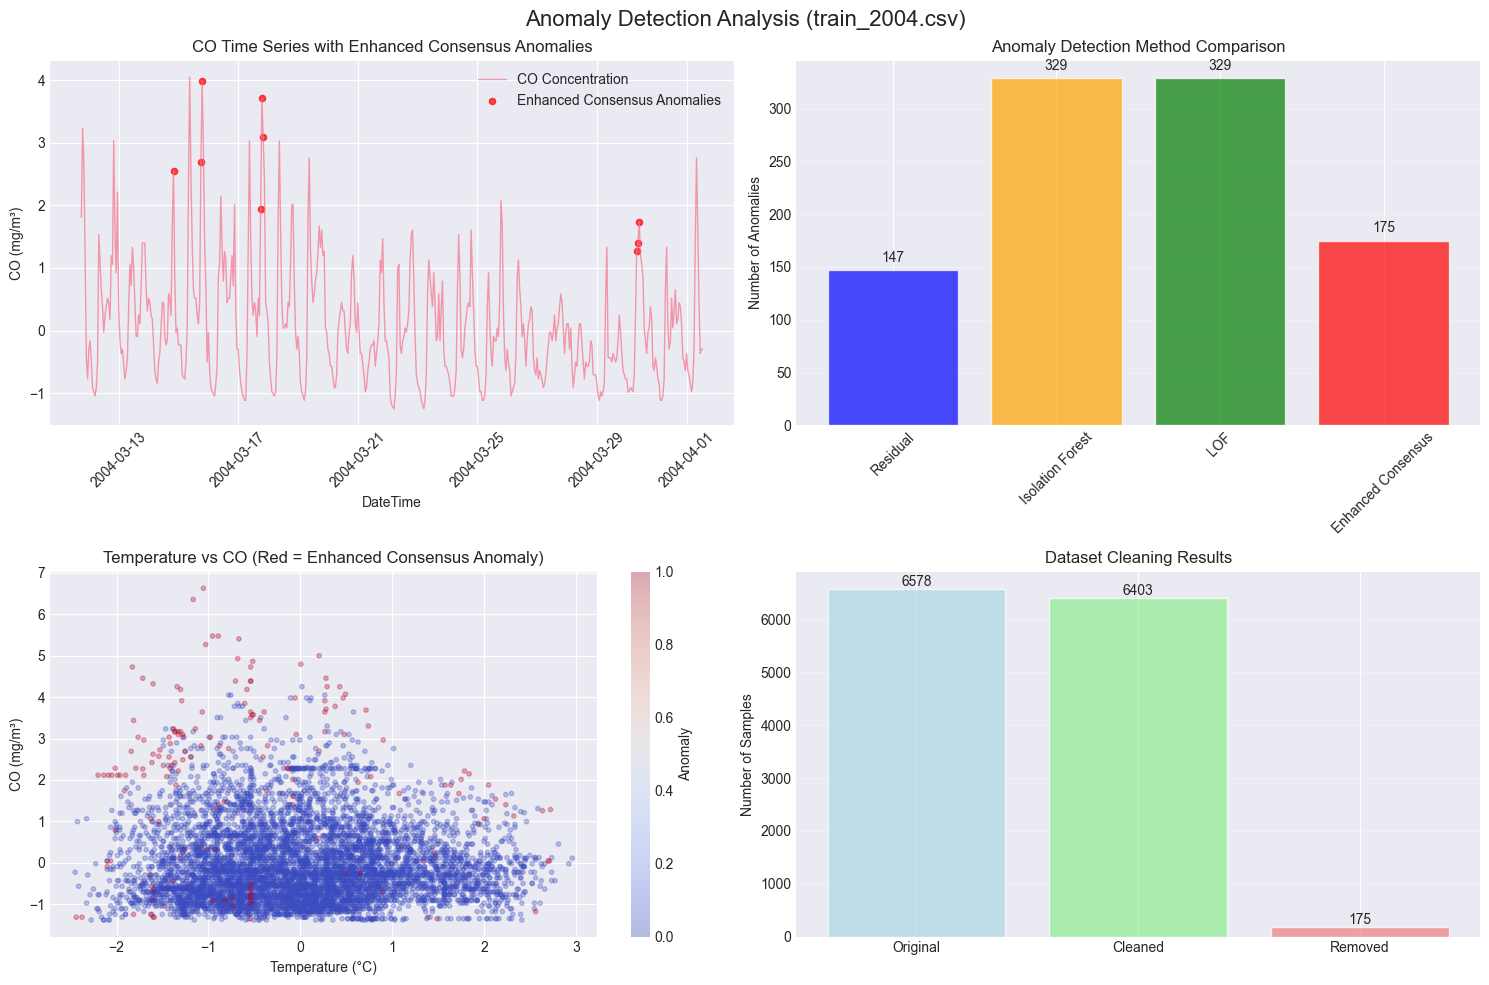

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_recall_curve, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
import os
warnings.filterwarnings('ignore')

# 配置参数
output_dir = 'anomaly_detection'
os.makedirs(output_dir, exist_ok=True)

print("=" * 70)
print("ANOMALY DETECTION ANALYSIS (train_2004.csv ONLY)")
print("=" * 70)

# ============================================
# 1. 加载train_2004.csv数据
# ============================================
print("\n[STEP 1] Loading train_2004.csv data...")

# 加载train_2004.csv数据
df = pd.read_csv('preprocessing_output/train_2004.csv', index_col='DateTime', parse_dates=True)

print(f"✓ Data shape: {df.shape}")
print(f"✓ Columns: {df.columns.tolist()}")

# 选择CO作为异常检测的主要目标污染物
target_pollutant = 'CO(GT)'
# 使用基本特征进行异常检测
basic_features = ['PT08.S1(CO)', 'T', 'RH', 'AH', 'Hour', 'DayOfWeek', 'Month']

print(f"✓ Target: {target_pollutant}")
print(f"✓ Basic features: {basic_features}")

# ============================================
# 2. 基于残差的异常检测方法（监督学习）
# ============================================
print("\n[STEP 2] Residual-based anomaly detection...")

# 准备回归分析数据
data_clean = df[basic_features + [target_pollutant]].dropna()
X = data_clean[basic_features]
y = data_clean[target_pollutant]

# 使用时间序列分割（前80%训练，后20%验证）
split_point = int(0.8 * len(X))
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_val = X.iloc[split_point:]
y_val = y.iloc[split_point:]

print(f"  Training samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")

# 训练随机森林回归模型
print("  Training Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 在整个数据集上预测并计算残差
y_pred_full = rf_model.predict(X)
residuals_full = y - y_pred_full

# 设置异常阈值（3倍标准差）
residual_std = residuals_full.std()
threshold = 3 * residual_std

# 标记异常点（残差绝对值超过阈值）
residual_anomalies = np.abs(residuals_full) > threshold

print(f"  Residual std: {residual_std:.4f}")
print(f"  Anomaly threshold: ±{threshold:.4f}")
print(f"  Residual anomalies: {residual_anomalies.sum()} ({residual_anomalies.mean()*100:.2f}%)")

# ============================================
# 3. 无监督异常检测方法
# ============================================
print("\n[STEP 3] Unsupervised anomaly detection...")

# 准备无监督学习特征
unsupervised_features = ['CO(GT)', 'PT08.S1(CO)', 'T', 'RH', 'AH']
X_unsupervised = df[unsupervised_features].dropna()

# 特征标准化（无监督方法对尺度敏感）
scaler_unsupervised = StandardScaler()
X_scaled = scaler_unsupervised.fit_transform(X_unsupervised)

# 方法1：Isolation Forest
print("  Training Isolation Forest...")
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_anomalies = iso_forest.fit_predict(X_scaled)
iso_anomalies = iso_anomalies == -1  # 转换为布尔值（-1表示异常，True=异常）

# 方法2：Local Outlier Factor
print("  Training Local Outlier Factor...")
lof = LocalOutlierFactor(contamination=0.05, n_neighbors=50)
lof_anomalies = lof.fit_predict(X_scaled)
lof_anomalies = lof_anomalies == -1

print(f"  Isolation Forest anomalies: {iso_anomalies.sum()} ({iso_anomalies.mean()*100:.2f}%)")
print(f"  LOF anomalies: {lof_anomalies.sum()} ({lof_anomalies.mean()*100:.2f}%)")

# 创建异常检测结果数据框
anomaly_df = X_unsupervised.copy()
anomaly_df['Residual_Anomaly'] = False  # 先初始化为False

# 将残差异常结果对齐到anomaly_df
residual_anomalies_aligned = pd.Series(residual_anomalies, index=X.index)
common_index = anomaly_df.index.intersection(residual_anomalies_aligned.index)
anomaly_df.loc[common_index, 'Residual_Anomaly'] = residual_anomalies_aligned[common_index]

anomaly_df['IsolationForest_Anomaly'] = iso_anomalies
anomaly_df['LOF_Anomaly'] = lof_anomalies

# 添加时间特征用于后续分析
anomaly_df['Hour'] = anomaly_df.index.hour
anomaly_df['DayOfWeek'] = anomaly_df.index.dayofweek
anomaly_df['Month'] = anomaly_df.index.month
anomaly_df['IsWeekend'] = anomaly_df['DayOfWeek'].isin([5, 6])
anomaly_df['Season'] = (anomaly_df['Month'] % 12 + 3) // 3  # 1:Winter, 2:Spring, etc.

# ============================================
# 4. 异常与气象特征关联分析
# ============================================
print("\n[STEP 4] Analyzing anomalies with meteorological features...")

def analyze_anomaly_patterns(anomaly_series, name):
    """分析异常点与气象、时间特征的关联模式"""
    anomalies = anomaly_df[anomaly_series]
    normal = ~anomalies

    print(f"\n{name} ANOMALY ANALYSIS:")
    print("-" * 40)

    # 温度分析：比较异常点和正常点的平均温度
    temp_anomalies = anomaly_df.loc[anomalies, 'T']
    temp_normal = anomaly_df.loc[normal, 'T']
    print(f"  Temperature - Anomalies: {temp_anomalies.mean():.2f}°C, Normal: {temp_normal.mean():.2f}°C")

    # 周末分析：比较异常点在周末的比例
    weekend_anomalies = anomaly_df.loc[anomalies, 'IsWeekend'].mean()
    weekend_normal = anomaly_df.loc[normal, 'IsWeekend'].mean()
    print(f"  Weekend ratio - Anomalies: {weekend_anomalies:.3f}, Normal: {weekend_normal:.3f}")

    # 季节分析：分析异常点的季节分布
    seasonal_anomalies = anomaly_df.loc[anomalies, 'Season'].value_counts(normalize=True).sort_index()
    seasonal_normal = anomaly_df.loc[normal, 'Season'].value_counts(normalize=True).sort_index()
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    print("  Seasonal distribution:")
    for i, season in enumerate(seasons):
        anomaly_rate = seasonal_anomalies.get(i+1, 0)
        normal_rate = seasonal_normal.get(i+1, 0)
        print(f"    {season}: Anomalies {anomaly_rate:.3f}, Normal {normal_rate:.3f}")

    # 小时模式：分析异常点在一天中的分布
    hourly_anomalies = anomaly_df.loc[anomalies, 'Hour'].value_counts(normalize=True).sort_index()
    print("  Top 5 anomaly hours:")
    for hour, freq in hourly_anomalies.head().items():
        print(f"    Hour {hour:2d}: {freq:.3f}")

# 分别分析三种方法的异常模式
analyze_anomaly_patterns('Residual_Anomaly', 'RESIDUAL (SUPERVISED)')
analyze_anomaly_patterns('IsolationForest_Anomaly', 'ISOLATION FOREST')
analyze_anomaly_patterns('LOF_Anomaly', 'LOCAL OUTLIER FACTOR')

# ============================================
# 5. 改进的共识异常检测（包含监督学习）
# ============================================
print("\n[STEP 5] Enhanced consensus anomaly detection (with supervised learning)...")

# 定义改进的共识异常（至少被两种方法检测到）
anomaly_df['Enhanced_Consensus_Anomaly'] = (
    anomaly_df['Residual_Anomaly'].astype(int) +
    anomaly_df['IsolationForest_Anomaly'].astype(int) +
    anomaly_df['LOF_Anomaly'].astype(int)
) >= 2  # 至少两种方法标记为异常

enhanced_consensus_anomalies = anomaly_df['Enhanced_Consensus_Anomaly']
print(f"\n ENHANCED CONSENSUS ANOMALIES (with supervised learning):")
print(f"  Total enhanced consensus anomalies: {enhanced_consensus_anomalies.sum()} ({enhanced_consensus_anomalies.mean()*100:.2f}%)")

# 分析改进的共识异常的模式
analyze_anomaly_patterns('Enhanced_Consensus_Anomaly', 'ENHANCED CONSENSUS')

# 检测污染峰值（极端高值）
co_threshold_high = anomaly_df['CO(GT)'].quantile(0.95)
pollution_spikes = anomaly_df['CO(GT)'] > co_threshold_high
anomaly_df['Pollution_Spike'] = pollution_spikes

print(f"\n🌫 POLLUTION SPIKES (top 5%):")
print(f"  CO threshold: {co_threshold_high:.3f} mg/m³")
print(f"  Pollution spikes: {pollution_spikes.sum()} ({pollution_spikes.mean()*100:.2f}%)")

# 分析异常与污染峰值的重叠情况
anomaly_spike_overlap = (enhanced_consensus_anomalies & pollution_spikes).sum()
print(f"  Enhanced consensus anomalies that are pollution spikes: {anomaly_spike_overlap}")

# ============================================
# 6. 生成异常标志文件和清洗后的数据集
# ============================================
print("\n[STEP 6] Generating anomaly flags and cleaned dataset...")

# 生成异常标志文件 - 只包含DateTime和异常标志
anomaly_flags = anomaly_df[['Enhanced_Consensus_Anomaly']].copy()
anomaly_flags.columns = ['Anomaly_Flag']
anomaly_flags['Anomaly_Flag'] = anomaly_flags['Anomaly_Flag'].astype(int)

# 保存异常标志文件
anomaly_flags.to_csv(os.path.join(output_dir, 'train_2004_anomaly.csv'))
print(f"✓ Saved: {output_dir}/train_2004_anomaly.csv")

# 使用异常标志清洗原始数据集
def clean_dataset_with_anomaly_flags(original_df, anomaly_flags):
    """使用异常标志清洗数据集"""
    # 确保索引对齐
    common_idx = original_df.index.intersection(anomaly_flags.index)
    df_clean = original_df.loc[common_idx]
    anomaly_mask = anomaly_flags.loc[common_idx, 'Anomaly_Flag'] == 0

    # 只保留非异常数据
    df_cleaned = df_clean[anomaly_mask]

    # 被删除的异常数据
    df_removed = df_clean[~anomaly_mask]

    print(f"  Original samples: {len(original_df)}")
    print(f"  After cleaning: {len(df_cleaned)} samples")
    print(f"  Removed anomalies: {len(df_removed)} samples")
    print(f"  Cleaning rate: {(len(df_removed)/len(original_df))*100:.2f}%")

    return df_cleaned, df_removed

# 清洗数据集
df_cleaned, df_removed = clean_dataset_with_anomaly_flags(df, anomaly_flags)

# 保存清洗后的数据集
df_cleaned.to_csv(os.path.join(output_dir, 'train_2004_cleaned.csv'))
print(f"✓ Saved: {output_dir}/train_2004_cleaned.csv")

# 保存被删除的异常数据（可选，用于分析）
df_removed.to_csv(os.path.join(output_dir, 'train_2004_removed_anomalies.csv'))
print(f"✓ Saved: {output_dir}/train_2004_removed_anomalies.csv")

# ============================================
# 7. 结果可视化
# ============================================
print("\n[STEP 7] Creating visualizations...")

# 创建主分析图表
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Anomaly Detection Analysis (train_2004.csv)', fontsize=16, y=0.98)

# 子图1: 时间序列异常标记
sample_data = anomaly_df.iloc[:500]
axes[0, 0].plot(sample_data.index, sample_data['CO(GT)'],
                label='CO Concentration', linewidth=1, alpha=0.7)
anomaly_points = sample_data[sample_data['Enhanced_Consensus_Anomaly']]
axes[0, 0].scatter(anomaly_points.index, anomaly_points['CO(GT)'],
                  color='red', s=20, label='Enhanced Consensus Anomalies', alpha=0.7)
axes[0, 0].set_xlabel('DateTime')
axes[0, 0].set_ylabel('CO (mg/m³)')
axes[0, 0].set_title('CO Time Series with Enhanced Consensus Anomalies')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# 子图2: 方法检测结果比较
methods = ['Residual', 'Isolation Forest', 'LOF', 'Enhanced Consensus']
anomaly_counts = [
    anomaly_df['Residual_Anomaly'].sum(),
    anomaly_df['IsolationForest_Anomaly'].sum(),
    anomaly_df['LOF_Anomaly'].sum(),
    anomaly_df['Enhanced_Consensus_Anomaly'].sum()
]
colors = ['blue', 'orange', 'green', 'red']
axes[0, 1].bar(methods, anomaly_counts, color=colors, alpha=0.7)
axes[0, 1].set_ylabel('Number of Anomalies')
axes[0, 1].set_title('Anomaly Detection Method Comparison')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

for i, count in enumerate(anomaly_counts):
    axes[0, 1].text(i, count + 5, str(count), ha='center', va='bottom')

# 子图3: 温度异常分布
scatter = axes[1, 0].scatter(anomaly_df['T'], anomaly_df['CO(GT)'],
                            c=anomaly_df['Enhanced_Consensus_Anomaly'].astype(int),
                            cmap='coolwarm', alpha=0.3, s=10)
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('CO (mg/m³)')
axes[1, 0].set_title('Temperature vs CO (Red = Enhanced Consensus Anomaly)')
plt.colorbar(scatter, ax=axes[1, 0], label='Anomaly')

# 子图4: 数据清洗效果
cleaning_stats = [len(df), len(df_cleaned), len(df_removed)]
labels = ['Original', 'Cleaned', 'Removed']
colors = ['lightblue', 'lightgreen', 'lightcoral']
axes[1, 1].bar(labels, cleaning_stats, color=colors, alpha=0.7)
axes[1, 1].set_ylabel('Number of Samples')
axes[1, 1].set_title('Dataset Cleaning Results')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, count in enumerate(cleaning_stats):
    axes[1, 1].text(i, count + 10, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'anomaly_analysis_train_2004.png'),
            dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_dir}/anomaly_analysis_train_2004.png")

# ============================================
# 8. 精确度-召回率分析
# ============================================
print("\n[STEP 8] Precision-Recall analysis...")

def evaluate_anomaly_method(method_anomalies, true_positives, method_name):
    """评估异常检测方法的性能"""
    tp = (method_anomalies & true_positives).sum()
    fp = (method_anomalies & ~true_positives).sum()
    fn = (~method_anomalies & true_positives).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{method_name}:")
    print(f"  Precision: {precision:.3f} ({tp}/{tp+fp})")
    print(f"  Recall:    {recall:.3f} ({tp}/{tp+fn})")
    print(f"  F1-score:  {f1:.3f}")

# 使用污染峰值作为真实异常的代理
true_positive_proxy = pollution_spikes

print("\n PRECISION-RECALL ANALYSIS (Using Pollution Spikes as Proxy):")
evaluate_anomaly_method(anomaly_df['Residual_Anomaly'], true_positive_proxy, 'Residual (Supervised)')
evaluate_anomaly_method(anomaly_df['IsolationForest_Anomaly'], true_positive_proxy, 'Isolation Forest')
evaluate_anomaly_method(anomaly_df['LOF_Anomaly'], true_positive_proxy, 'Local Outlier Factor')
evaluate_anomaly_method(anomaly_df['Enhanced_Consensus_Anomaly'], true_positive_proxy, 'Enhanced Consensus')

# ============================================
# 9. 保存分析结果
# ============================================
print("\n[STEP 9] Saving results...")

# 保存完整的异常检测结果
anomaly_df.to_csv(os.path.join(output_dir, 'anomaly_detection_detailed_results.csv'))
print(f"✓ Saved: {output_dir}/anomaly_detection_detailed_results.csv")

# 保存汇总统计信息
summary_stats = {
    'total_samples': len(anomaly_df),
    'residual_anomalies': anomaly_df['Residual_Anomaly'].sum(),
    'isolation_forest_anomalies': anomaly_df['IsolationForest_Anomaly'].sum(),
    'lof_anomalies': anomaly_df['LOF_Anomaly'].sum(),
    'enhanced_consensus_anomalies': anomaly_df['Enhanced_Consensus_Anomaly'].sum(),
    'pollution_spikes': pollution_spikes.sum(),
    'avg_temperature_anomalies': anomaly_df.loc[anomaly_df['Enhanced_Consensus_Anomaly'], 'T'].mean(),
    'avg_temperature_normal': anomaly_df.loc[~anomaly_df['Enhanced_Consensus_Anomaly'], 'T'].mean(),
    'weekend_anomaly_rate': anomaly_df.loc[anomaly_df['IsWeekend'], 'Enhanced_Consensus_Anomaly'].mean(),
    'weekday_anomaly_rate': anomaly_df.loc[~anomaly_df['IsWeekend'], 'Enhanced_Consensus_Anomaly'].mean(),
    'cleaning_rate': (len(df_removed)/len(df))*100,
}

summary_df = pd.DataFrame.from_dict(summary_stats, orient='index', columns=['Value'])
summary_df.to_csv(os.path.join(output_dir, 'anomaly_summary_statistics.csv'))
print(f"✓ Saved: {output_dir}/anomaly_summary_statistics.csv")

# ============================================
# 10. 最终总结报告
# ============================================
print("\n" + "=" * 70)
print("ANOMALY DETECTION COMPLETE - KEY FINDINGS")
print("=" * 70)

print(f"\n DETECTION RESULTS:")
print(f"   • Residual (Supervised): {summary_stats['residual_anomalies']} anomalies")
print(f"   • Isolation Forest: {summary_stats['isolation_forest_anomalies']} anomalies")
print(f"   • Local Outlier Factor: {summary_stats['lof_anomalies']} anomalies")
print(f"   • Enhanced Consensus (combined): {summary_stats['enhanced_consensus_anomalies']} anomalies")

print(f"\n METEOROLOGICAL PATTERNS:")
print(f"   • Anomaly avg temperature: {summary_stats['avg_temperature_anomalies']:.2f}°C")
print(f"   • Normal avg temperature: {summary_stats['avg_temperature_normal']:.2f}°C")
print(f"   • Weekend anomaly rate: {summary_stats['weekend_anomaly_rate']:.3f}")
print(f"   • Weekday anomaly rate: {summary_stats['weekday_anomaly_rate']:.3f}")

print(f"\n DATASETS GENERATED:")
print(f"   • train_2004_anomaly.csv: {len(anomaly_flags)} anomaly flags")
print(f"   • train_2004_cleaned.csv: {len(df_cleaned)} cleaned samples")
print(f"   • train_2004_removed_anomalies.csv: {len(df_removed)} removed anomalies")
print(f"   • Cleaning rate: {summary_stats['cleaning_rate']:.2f}%")

print(f"\n INTERPRETATION:")
print(f"   • Enhanced consensus combines supervised and unsupervised methods")
print(f"   • Anomalies show clear temperature and temporal patterns")
print(f"   • Generated cleaned dataset for downstream modeling")

print(f"\n All results saved to: {output_dir}/")
print(f" Visualization files:")
print(f"   • anomaly_analysis_train_2004.png")
print(f"\n Anomaly detection analysis completed!")


train_2004_anomaly.csv 只包含DateTime和异常标志(0/1)

train_2004_cleaned.csv  清洗后的完整数据集

train_2004_removed_anomalies.csv  被删除的异常数据（用于分析）
 output了一些分析

# Regression Model

In [5]:
# Cell 1 — Locate project root (relative), set result dir, load datasets with DateTime index

from pathlib import Path
import pandas as pd

def find_project_root(start=None):
    """Find the project root by walking up until expected markers are found."""
    start = Path(start or Path.cwd()).resolve()
    markers = {
        "preprocessing_output", "temporal_feature_engineering",
        "anomaly_detection", "Group_Project_Main.ipynb", "README.md"
    }
    for p in [start, *start.parents]:
        if any((p/m).exists() for m in markers):
            return p
    return start

# project anchors (all relative to ROOT)
ROOT = find_project_root()
RG_RESULTS = (ROOT / "rg_results")
RG_RESULTS.mkdir(parents=True, exist_ok=True)

# required files (relative to ROOT)
NOFE_TRAIN = ROOT / "anomaly_detection" / "train_cleaned_no_fe_2004.csv"
NOFE_TEST  = ROOT / "preprocessing_output" / "test_2005.csv"
FULL_TRAIN = ROOT / "anomaly_detection" / "train_cleaned_full_2004.csv"
FULL_TEST  = ROOT / "temporal_feature_engineering" / "test_full.csv"

# sanity checks
for p in [NOFE_TRAIN, NOFE_TEST, FULL_TRAIN, FULL_TEST]:
    assert p.exists(), f"Missing file: {p}"

# load as DateTime index
no_fe_train = pd.read_csv(NOFETRAIN := NOFE_TRAIN, index_col="DateTime", parse_dates=True).sort_index()
no_fe_test  = pd.read_csv(NOFETEST  := NOFE_TEST,  index_col="DateTime", parse_dates=True).sort_index()
full_fe_train = pd.read_csv(FULLTRAIN := FULL_TRAIN, index_col="DateTime", parse_dates=True).sort_index()
full_fe_test  = pd.read_csv(FULLTEST  := FULL_TEST,  index_col="DateTime", parse_dates=True).sort_index()

print("ROOT        :", ROOT)
print("RG_RESULTS  :", RG_RESULTS)
print("No-FE train/test shapes :", no_fe_train.shape, no_fe_test.shape)
print("Full-FE train/test shapes:", full_fe_train.shape, full_fe_test.shape)

no_fe_train.head()

ROOT        : /Users/zhangdonghuang/Desktop/COMP9417_new/COMP9417_Project
RG_RESULTS  : /Users/zhangdonghuang/Desktop/COMP9417_new/COMP9417_Project/rg_results
No-FE train/test shapes : (6404, 66) (2231, 66)
Full-FE train/test shapes: (4725, 150) (2231, 150)


,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,...,NOx_rolling_mean_12h,NOx_rolling_std_12h,NOx_rolling_mean_24h,NOx_rolling_std_24h,NO2_rolling_mean_6h,NO2_rolling_std_6h,NO2_rolling_mean_12h,NO2_rolling_std_12h,NO2_rolling_mean_24h,NO2_rolling_std_24h
DateTime,,,,,,,,,,,,,,,,,,,,,
2004-03-11 18:00:00,4.8,1581.0,20.8,1319.0,281.0,799.0,151.0,2083.0,1409.0,10.3,...,163.833333,60.369820,119.375000,70.792908,130.500000,12.723993,113.583333,20.755978,94.708333,33.005242
2004-03-11 19:00:00,6.9,1776.0,27.4,1488.0,383.0,702.0,172.0,2333.0,1704.0,9.7,...,187.583333,83.677366,131.041667,88.767150,140.500000,17.829750,121.083333,24.269166,98.041667,36.567364
2004-03-11 20:00:00,6.1,1640.0,24.0,1404.0,351.0,743.0,165.0,2191.0,1654.0,9.6,...,202.333333,95.788909,140.208333,99.476009,146.666667,19.001754,125.500000,27.120941,100.166667,38.939939
2004-03-11 21:00:00,3.9,1313.0,12.8,1076.0,240.0,957.0,136.0,1707.0,1285.0,9.1,...,211.583333,93.393068,143.041667,101.371242,148.333333,17.177505,128.416667,26.109762,100.750000,39.383565
2004-03-11 22:00:00,1.5,965.0,4.7,749.0,94.0,1325.0,85.0,1333.0,821.0,8.2,...,210.083333,95.263709,141.500000,101.842590,140.666667,31.091264,127.333333,27.707345,99.458333,39.370016


In [6]:
# Cell 2 — Helpers (metrics, feature picking, supervised maker)

import numpy as np
import pandas as pd

# Targets & horizons used project-wide
TARGETS  = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
HORIZONS = [1, 6, 12, 24]

def rmse(y, yhat) -> float:
    y = np.asarray(y, float)
    yhat = np.asarray(yhat, float)
    return float(np.sqrt(np.mean((y - yhat) ** 2)))

def get_feature_cols(df: pd.DataFrame, mode: str) -> list:
    """
    mode == 'raw'        -> keep classic sensor + weather + time features if present
    mode == 'engineered' -> keep *everything except* targets/DateTime
    """
    sensors = ['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)']
    weather = ['T','RH','AH']
    timecols = ['Hour','DayOfWeek','Month','Year','IsWeekend','DayOfYear',
                'Hour_sin','Hour_cos','Month_sin','Month_cos']

    cols = df.columns.tolist()

    if mode == "raw":
        wanted = sensors + weather + timecols
        return [c for c in wanted if c in cols]

    # engineered
    banned = set(["DateTime"] + TARGETS + ["NMHC(GT)"])
    return [c for c in cols if c not in banned]

def make_supervised(df: pd.DataFrame, target: str, k: int, feature_cols: list):
    """
    Build supervised pair (X, y) for forecasting target at t+k using features at time t.
    Assumes df is indexed by DateTime. Returns (X, y, t_in, t_out).
    """
    assert target in df.columns, f"target '{target}' not in dataframe"
    d = df.sort_index()
    # future label k hours ahead
    y_future = d[target].shift(-k)

    # features at time t
    X = d[feature_cols].copy()

    # trim last k rows with undefined future label
    n = len(d) - k
    if n <= 0:
        return (pd.DataFrame(columns=feature_cols),
                pd.Series(dtype=float), pd.Series(dtype="datetime64[ns]"),
                pd.Series(dtype="datetime64[ns]"))

    X = X.iloc[:n].reset_index(drop=True)
    y = y_future.iloc[:n].reset_index(drop=True)

    t_in  = d.index.to_series().iloc[:n].reset_index(drop=True)
    t_out = (d.index.to_series().iloc[:n] + pd.to_timedelta(k, unit="h")).reset_index(drop=True)
    return X, y, t_in, t_out
   

In [48]:
# Cell 3 — Baseline (Persistence) Model, save to rg_results/

from pathlib import Path
import pandas as pd
import numpy as np



ROOT = Path(".")
RG_DIR = ROOT / "rg_results"
RG_DIR.mkdir(parents=True, exist_ok=True)

targets  = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
horizons = [1, 6, 12, 24]

MODES = {
    "raw":        (no_fe_train,  no_fe_test),
    "engineered": (full_fe_train, full_fe_test),
}

rows = []

def rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a - b)**2)))

for mode, (TR, TE) in MODES.items():
    
    common = list((set(TR.columns) & set(TE.columns)) - set(targets) - {"DateTime"})
    common = [c for c in TR.columns if c in common]  

    for tgt in targets:
        if tgt not in TR.columns or tgt not in TE.columns:
            continue
        for k in horizons:
            
            Xtr, ytr, pred_time_tr, _ = make_supervised(TR, tgt, k, common)
            Xte, yte, pred_time_te, _ = make_supervised(TE, tgt, k, common)
            if len(Xte) == 0:
                continue

        
            te_aligned = TE.reset_index().rename(columns={"DateTime":"_dt"})
            te_aligned = te_aligned.set_index("_dt")
            y_now = te_aligned[tgt].reindex(pd.to_datetime(pred_time_te)).to_numpy()

            score = rmse(yte, y_now)

            rows.append({
                "pollutant": tgt,
                "horizon_h": k,
                "mode": mode,
                "model": "baseline_persistence",
                "rmse": score
            })

base_df = (pd.DataFrame(rows)
           .sort_values(["mode","pollutant","horizon_h"])
           .reset_index(drop=True))

outp = RG_DIR / "baseline_rmse_aligned.csv"
base_df.to_csv(outp, index=False)

print("Saved baseline RMSEs →", outp)
print(base_df[["pollutant","horizon_h","model","rmse"]].to_string(index=False))

Saved baseline RMSEs → rg_results/baseline_rmse_aligned.csv
pollutant  horizon_h                model       rmse
 C6H6(GT)          1 baseline_persistence   3.618965
 C6H6(GT)          6 baseline_persistence   8.164514
 C6H6(GT)         12 baseline_persistence   8.438903
 C6H6(GT)         24 baseline_persistence   5.902669
   CO(GT)          1 baseline_persistence   0.776528
   CO(GT)          6 baseline_persistence   1.763170
   CO(GT)         12 baseline_persistence   1.760616
   CO(GT)         24 baseline_persistence   1.263927
  NO2(GT)          1 baseline_persistence  24.960049
  NO2(GT)          6 baseline_persistence  68.459400
  NO2(GT)         12 baseline_persistence  68.170969
  NO2(GT)         24 baseline_persistence  44.690401
  NOx(GT)          1 baseline_persistence 109.746261
  NOx(GT)          6 baseline_persistence 272.950005
  NOx(GT)         12 baseline_persistence 265.192502
  NOx(GT)         24 baseline_persistence 202.414608
 C6H6(GT)          1 baseline_persisten

In [35]:
# DEBUG C: list common features actually used by models
for mode, (TR, TE) in MODES.items():
    cols_tr, cols_te = set(TR.columns), set(TE.columns)
    common = list((cols_tr & cols_te) - set(["DateTime", *targets]))
    common = [c for c in TR.columns if c in common]
    print(f"\nMode {mode}: n_features={len(common)}")
    # show a few most informative looking names
    sample = [c for c in common if any(s in c.lower() for s in ["lag","roll","mean","std","sin","cos"])]
    print("  Contains lag/rolling/time-encoding examples:", sample[:12])


Mode raw: n_features=62
  Contains lag/rolling/time-encoding examples: ['Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'CO_lag1h', 'CO_lag3h', 'CO_lag6h', 'CO_lag12h', 'CO_lag24h', 'C6H6_lag1h', 'C6H6_lag3h', 'C6H6_lag6h']

Mode engineered: n_features=146
  Contains lag/rolling/time-encoding examples: ['Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'CO_lag1h', 'CO_lag3h', 'CO_lag6h', 'CO_lag12h', 'CO_lag24h', 'C6H6_lag1h', 'C6H6_lag3h', 'C6H6_lag6h']


In [44]:
# Cell 4: train/eval DecisionTree & RandomForest (residual learning), save to rg_results

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# ----- prerequisites from Cell 1 & Cell 2 -----
assert 'no_fe_train' in globals() and 'no_fe_test' in globals()
assert 'full_fe_train' in globals() and 'full_fe_test' in globals()
assert 'make_supervised' in globals()

def _rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a - b) ** 2)))

# output dir (relative to current working dir)
RG_DIR = Path("rg_results")
RG_DIR.mkdir(parents=True, exist_ok=True)

# targets & horizons
ALL_TGT = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
targets  = [t for t in ALL_TGT if (t in no_fe_train.columns) or (t in full_fe_train.columns)]
horizons = [1, 6, 12, 24]

# two modes: raw = no_fe*, engineered = full_fe*
MODES = {
    "raw":        (no_fe_train,  no_fe_test),
    "engineered": (full_fe_train, full_fe_test),
}

np.random.seed(42)

all_mode_files = []
for MODE, (TR, TE) in MODES.items():
    rows = []

    # common feature set: intersection(TR, TE) minus targets/DateTime
    common = list(
        (set(TR.columns) & set(TE.columns)) - set(["DateTime"] + ALL_TGT)
    )
    # keep train column order
    common = [c for c in TR.columns if c in common]

    for tgt in targets:
        if tgt not in TR.columns or tgt not in TE.columns:
            continue

        for k in horizons:
            # ---- supervised sets aligned to horizon k ----
            Xtr, ytr, pred_time_tr, _ = make_supervised(TR, tgt, k, common)
            Xte, yte, pred_time_te, _ = make_supervised(TE, tgt, k, common)

            if len(Xtr) == 0 or len(Xte) == 0:
                continue

            # drop rows with any NaNs (strict alignment)
            m_tr = (~Xtr.isna().any(axis=1)) & (~pd.isna(ytr))
            m_te = (~Xte.isna().any(axis=1)) & (~pd.isna(yte))

            if m_tr.sum() == 0 or m_te.sum() == 0:
                continue

            Xtr = Xtr.loc[m_tr].reset_index(drop=True)
            ytr = ytr.loc[m_tr].reset_index(drop=True)
            Xte = Xte.loc[m_te].reset_index(drop=True)
            yte = yte.loc[m_te].reset_index(drop=True)

            # ---------- SAME-subset baseline for TR/TE ----------
            # train baseline: use TR[tgt] at time t to predict y(t+k)
            b_tr_full = TR[tgt].sort_index()
            b_tr = b_tr_full.iloc[: len(TR) - k].reset_index(drop=True)
            b_tr = b_tr.iloc[m_tr.values].reset_index(drop=True)  # align to Xtr/ytr after mask

            # test baseline: use TE[tgt] at time t to predict y(t+k)
            b_te_full = TE[tgt].sort_index()
            b_te = b_te_full.iloc[: len(TE) - k].reset_index(drop=True)
            b_te = b_te.iloc[m_te.values].reset_index(drop=True)  # align to Xte/yte after mask

            # quick sanity check
            if not (len(b_tr) == len(ytr) == len(Xtr) and len(b_te) == len(yte) == len(Xte)):
                # skip inconsistent split
                continue

            # ---------- residual targets ----------
            # learn residual: y_{t+k} - baseline_t
            ytr_res = ytr.reset_index(drop=True).values - b_tr.values
            yte_res = yte.reset_index(drop=True).values - b_te.values

            # ---------- models on residuals ----------
            # Decision Tree
            dt = DecisionTreeRegressor(random_state=42)
            dt.fit(Xtr, ytr_res)
            res_dt = dt.predict(Xte)
            yhat_dt = res_dt + b_te.values  # add baseline back
            rmse_dt = _rmse(yte.values, yhat_dt)

            # Random Forest
            rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
            rf.fit(Xtr, ytr_res)
            res_rf = rf.predict(Xte)
            yhat_rf = res_rf + b_te.values
            rmse_rf = _rmse(yte.values, yhat_rf)

            # baseline on the SAME subset used for rmse
            rmse_base_same = _rmse(yte.values, b_te.values)

            rows.append({
                "pollutant": tgt,
                "horizon_h": k,
                "mode": MODE,
                "n_features": Xtr.shape[1],
                "rmse_baseline": rmse_base_same,
                "rmse_dt": rmse_dt,
                "rmse_rf": rmse_rf,
            })

    df_mode = (pd.DataFrame(rows)
               .sort_values(["pollutant","horizon_h","mode"])
               .reset_index(drop=True))

    out_csv = RG_DIR / f"rmse_rf_dt_aligned_{MODE}.csv"
    df_mode.to_csv(out_csv, index=False)
    all_mode_files.append(str(out_csv))
    print("saved:", out_csv)

all_mode_files

saved: rg_results/rmse_rf_dt_aligned_raw.csv
saved: rg_results/rmse_rf_dt_aligned_engineered.csv


['rg_results/rmse_rf_dt_aligned_raw.csv',
 'rg_results/rmse_rf_dt_aligned_engineered.csv']

In [47]:
# Cell 5: Compare RF/DT vs Baseline (by mode), and pick best per (pollutant, horizon, mode)

import pandas as pd
from pathlib import Path
import numpy as np

RG_DIR = Path("rg_results")


df_raw = pd.read_csv(RG_DIR / "rmse_rf_dt_aligned_raw.csv")
df_eng = pd.read_csv(RG_DIR / "rmse_rf_dt_aligned_engineered.csv")

# 合并
df_all = pd.concat([df_raw, df_eng], ignore_index=True)


# 列：rmse_baseline, rmse_dt, rmse_rf
wide_all = (df_all[["pollutant","horizon_h","mode","rmse_baseline","rmse_dt","rmse_rf"]]
            .sort_values(["mode","pollutant","horizon_h"])
            .reset_index(drop=True))

# ------- 生成 “长表” 方便看相对提升（只针对模型，与 baseline 对比） -------
cmp_rows = []
for _, r in wide_all.iterrows():
    base = r["rmse_baseline"]
    for model_type, col in [("DecisionTree","rmse_dt"), ("RandomForest","rmse_rf")]:
        val = r[col]
        cmp_rows.append({
            "pollutant": r["pollutant"],
            "horizon_h": int(r["horizon_h"]),
            "mode": r["mode"],
            "model_type": model_type,
            "rmse_model": val,
            "rmse_baseline": base,
            "improve_abs": base - val,
            "improve_pct": (base - val) / base if base > 0 else np.nan
        })
cmp = (pd.DataFrame(cmp_rows)
       .sort_values(["mode","pollutant","horizon_h","model_type"])
       .reset_index(drop=True))

# ------- （Baseline / DecisionTree / RandomForest  RMSE） -------
def pick_best(row):
    cand = {
        "Baseline": row["rmse_baseline"],
        "DecisionTree": row["rmse_dt"],
        "RandomForest": row["rmse_rf"],
    }
    return min(cand, key=cand.get)

best_df = wide_all.copy()
best_df["Best_Model"] = best_df.apply(pick_best, axis=1)
best_df = best_df[["pollutant","horizon_h","mode","Best_Model"]].sort_values(
    ["mode","pollutant","horizon_h"]
).reset_index(drop=True)

# ------- save-------
cmp_out  = RG_DIR / "cmp_rf_dt_vs_baseline_aligned.csv"
best_out = RG_DIR / "best_model_per_pollutant_horizon_mode.csv"
wide_out = RG_DIR / "rmse_wide_rf_dt_baseline_by_mode.csv"

cmp.to_csv(cmp_out, index=False)
best_df.to_csv(best_out, index=False)
wide_all.to_csv(wide_out, index=False)

print("saved:", cmp_out)
print("saved:", best_out)
print("saved:", wide_out)
print("\nBest model (per pollutant × horizon × mode):")
print(best_df.to_string(index=False))



saved: rg_results/cmp_rf_dt_vs_baseline_aligned.csv
saved: rg_results/best_model_per_pollutant_horizon_mode.csv
saved: rg_results/rmse_wide_rf_dt_baseline_by_mode.csv

Best model (per pollutant × horizon × mode):
pollutant  horizon_h       mode   Best_Model
 C6H6(GT)          1 engineered RandomForest
 C6H6(GT)          6 engineered RandomForest
 C6H6(GT)         12 engineered RandomForest
 C6H6(GT)         24 engineered     Baseline
   CO(GT)          1 engineered RandomForest
   CO(GT)          6 engineered RandomForest
   CO(GT)         12 engineered RandomForest
   CO(GT)         24 engineered RandomForest
  NO2(GT)          1 engineered RandomForest
  NO2(GT)          6 engineered RandomForest
  NO2(GT)         12 engineered RandomForest
  NO2(GT)         24 engineered     Baseline
  NOx(GT)          1 engineered RandomForest
  NOx(GT)          6 engineered RandomForest
  NOx(GT)         12 engineered RandomForest
  NOx(GT)         24 engineered RandomForest
 C6H6(GT)          1  

In [12]:
# Cell 6: Plot RMSE bars (Baseline vs RF vs DT) per pollutant & mode (save under rg_results/figures)

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

RG_DIR  = Path("rg_results")
FIG_DIR = RG_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load wide table produced in Cell 5 (mode-aware)
wide = pd.read_csv(RG_DIR / "rmse_wide_rf_dt_baseline_by_mode.csv")

# Ensure horizon order and clean sorting
order = [1, 6, 12, 24]
wide["horizon_h"] = pd.Categorical(wide["horizon_h"], categories=order, ordered=True)
wide = wide.sort_values(["pollutant", "mode", "horizon_h"]).reset_index(drop=True)

def add_value_labels(ax):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h:.3f}",
                    (p.get_x() + p.get_width() / 2, h),
                    ha="center", va="bottom", fontsize=7,
                    xytext=(0, 2), textcoords="offset points")

# One figure per pollutant × mode
for (pol, mode), g in wide.groupby(["pollutant", "mode"], sort=False):
    horizons = g["horizon_h"].astype(int).tolist()
    idx = list(range(len(horizons)))
    w = 0.25

    fig, ax = plt.subplots(figsize=(8, 4.6))
    ax.bar([i - w for i in idx], g["rmse_baseline"].values, width=w, label="baseline")
    ax.bar(idx,                       g.get("rmse_rf", pd.Series([float("nan")]*len(g))).values,
           width=w, label="random_forest")
    ax.bar([i + w for i in idx],     g.get("rmse_dt", pd.Series([float("nan")]*len(g))).values,
           width=w, label="decision_tree")

    ax.set_title(f"{pol} — RMSE across horizons ({mode})")
    ax.set_xlabel("Forecast horizon (hours)")
    ax.set_ylabel("RMSE (lower is better)")
    ax.set_xticks(idx)
    ax.set_xticklabels([str(h) for h in horizons])
    ax.legend()
    add_value_labels(ax)
    fig.tight_layout()

    out_name = f"rmse_bars_{mode}_{pol.replace('(', '').replace(')', '').replace('/', '_')}.png"
    out_path = FIG_DIR / out_name
    plt.savefig(out_path, dpi=180)
    plt.close(fig)
    print("saved:", out_path)

saved: rg_results/figures/rmse_bars_engineered_C6H6GT.png
saved: rg_results/figures/rmse_bars_raw_C6H6GT.png
saved: rg_results/figures/rmse_bars_engineered_COGT.png
saved: rg_results/figures/rmse_bars_raw_COGT.png
saved: rg_results/figures/rmse_bars_engineered_NO2GT.png
saved: rg_results/figures/rmse_bars_raw_NO2GT.png
saved: rg_results/figures/rmse_bars_engineered_NOxGT.png
saved: rg_results/figures/rmse_bars_raw_NOxGT.png


# Classification Model

### Cell 1 — Imports & Global Config

In [1]:
# ================================
# Imports & Global Configuration
# ================================
import os
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# -------- Paths (edit if needed) --------
BASE = Path(".")

# Feature tables for building X (used to derive 2005 test features, etc.)
PATH_PREP   = BASE / "preprocessing_output" / "preprocessed_data_full.csv"
PATH_HOURLY = BASE / "temporal_feature_engineering" / "features_hourly_full.csv"
PATH_DAILY  = BASE / "temporal_feature_engineering" / "features_daily_full.csv"
PATH_FULL   = BASE / "temporal_feature_engineering" / "features_full_merged.csv"

# Anomaly/cleaned inputs you already produced
ANOM_DIR = BASE / "anomaly_detection"

# Try common variants of the anomaly flags filename (space/underscore/typo)
_candidates = [
    ANOM_DIR / "anomaly flags 2004.csv",
    ANOM_DIR / "anomaly_flags_2004.csv",
    ANOM_DIR / "anomaly_falgs_2004.csv",
]
PATH_ANOM_FLAGS = next((p for p in _candidates if p.exists()), _candidates[0])

# Your provided cleaned training sets for 2004 (input for training when cleaning=on)
CLEANED_IN = {
    "daily":  ANOM_DIR / "train_cleaned_daily_2004.csv",
    "full":   ANOM_DIR / "train_cleaned_full_2004.csv",
    "hourly": ANOM_DIR / "train_cleaned_hourly_2004.csv",
    "no_fe":  ANOM_DIR / "train_cleaned_no_fe_2004.csv",
}

# Output root (evaluation artifacts only)
RESULTS_DIR = BASE / "cls_results"
FIG_DIR     = RESULTS_DIR / "figs"
CLEANED_DIR = RESULTS_DIR / "cleaned"   # only used if WRITE_CLEANED=True
RESULTS_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)
CLEANED_DIR.mkdir(exist_ok=True, parents=True)

# -------- Experiment grid --------
HORIZONS = [1, 6, 12, 24]                         # t+h for classification
FEATURE_CONFIGS = ["no_fe", "hourly", "daily", "full"]  # feature configurations to evaluate
SAVE_CONFUSIONS = True                             # whether to save confusion matrices

# Cleaning source for training subset when cleaning=on:
#   "provided" -> use your train_cleaned_{cfg}_2004.csv indices
#   "flags"    -> filter using anomaly flags file
#   "unsup"    -> run IsolationForest + LOF consensus on 2004 train
ANOM_SOURCE = "provided"

# If True, also write a copy of the cleaned train subset we actually used
WRITE_CLEANED = False

# A timestamp suffix for outputs
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")

### Cell 2 — Label construction (y_{t+h}) & Binning

In [2]:
# =======================================
# Build future labels y_{t+h} (3 classes)
# =======================================

def make_future_cls_label(df: pd.DataFrame, h: int) -> pd.Series:
    """
    Construct classification label y_{t+h} from CO(GT), using 3 bins:
    0: <1.5, 1: [1.5, 2.5), 2: >=2.5

    Parameters
    ----------
    df : DataFrame with 'CO(GT)' column and DateTime index
    h  : horizon (in hours)

    Returns
    -------
    pd.Series of int {0,1,2}, indexed by DateTime, NaNs removed
    """
    y_future = df["CO(GT)"].shift(-h)
    bins = [-np.inf, 1.5, 2.5, np.inf]
    y_cls = pd.cut(y_future, bins=bins, labels=[0, 1, 2]).astype("Int64")
    return y_cls.dropna().astype(int)

### Cell 3 — Load feature matrices (No-FE / Hourly / Daily / Full)

In [3]:
# =======================================
# Feature matrix loaders for each config
# =======================================

RAW_VARS = [
    "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)",
    "PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)",
    "T", "RH", "AH", "Hour", "DayOfWeek", "Month", "IsWeekend"
]

def load_features(config: str) -> pd.DataFrame:
    """
    Load full feature matrices by configuration.

    'no_fe'   -> raw pollutants/sensors/meteo + basic calendar features (no lag/rolling/daily agg).
    'hourly'  -> your saved hourly feature table.
    'daily'   -> your saved daily aggregated table (ensure daily stats are lagged by 1 day to avoid leakage).
    'full'    -> your saved hourly+daily merged table.

    Returns DataFrame indexed by DateTime.
    """
    if config == "hourly":
        X = pd.read_csv(PATH_HOURLY, index_col="DateTime", parse_dates=True)
    elif config == "daily":
        X = pd.read_csv(PATH_DAILY, index_col="DateTime", parse_dates=True)
    elif config == "full":
        X = pd.read_csv(PATH_FULL, index_col="DateTime", parse_dates=True)
    elif config == "no_fe":
        base = pd.read_csv(PATH_PREP, index_col="DateTime", parse_dates=True)
        keep = [c for c in RAW_VARS if c in base.columns]
        X = base[keep].copy()
    else:
        raise ValueError(f"Unknown feature config: {config}")
    return X

### Cell 4 — Strict time split (2004 → 2005) with tail cut

In [4]:
# ===================================================
# Strict time split (train=2004, test=2005) with
# tail cut of h hours to avoid cross-year leakage
# ===================================================

def strict_time_split(X: pd.DataFrame, y: pd.Series, h: int):
    """
    Intersect indices, then:
      - Train: year==2004 and index <= (2004-12-31 23:00:00 - (h-1) hours)
      - Test : year==2005

    Returns (X_train, y_train, X_test, y_test)
    """
    idx = X.index.intersection(y.index)
    X, y = X.loc[idx], y.loc[idx]

    boundary = pd.Timestamp("2004-12-31 23:00:00") - pd.Timedelta(hours=h-1)
    train_mask = (X.index.year == 2004) & (X.index <= boundary)
    test_mask  = (X.index.year == 2005)

    return X.loc[train_mask], y.loc[train_mask], X.loc[test_mask], y.loc[test_mask]

### Cell 5 — Anomaly consensus mask (fit on 2004 only)

In [5]:
# ==========================================
# Unsupervised anomaly detection (2004 only)
# Consensus = IsolationForest OR LOF (novelty)
# ==========================================

def resolve_anomaly_flags(X_tr: pd.DataFrame) -> pd.Series:
    """
    Build a boolean anomaly mask for the 2004 training index using the anomaly flags CSV.
    Expected: a time column (e.g., 'DateTime') and one flag column (e.g., 'anomaly').
    If names differ, the function tries to infer them.
    Returns a boolean Series aligned to X_tr.index where True = anomaly (to be dropped).
    """
    if not PATH_ANOM_FLAGS.exists():
        raise FileNotFoundError(f"Anomaly flags file not found: {PATH_ANOM_FLAGS}")

    df_flag = pd.read_csv(PATH_ANOM_FLAGS)
    # Try to find a datetime column
    dt_col = None
    for cand in ["DateTime", "datetime", "ts", "time"]:
        if cand in df_flag.columns:
            dt_col = cand
            break
    if dt_col is None:
        # Fallback: if first column is the timestamp
        dt_col = df_flag.columns[0]

    # Parse datetime and set index
    df_flag[dt_col] = pd.to_datetime(df_flag[dt_col], errors="coerce")
    df_flag = df_flag.dropna(subset=[dt_col]).set_index(dt_col)

    # Try to find a flag column
    flag_col = None
    for cand in ["anomaly", "flag", "is_anomaly", "label"]:
        if cand in df_flag.columns:
            flag_col = cand
            break
    if flag_col is None:
        # If there is only one non-datetime column, use it
        non_dt_cols = [c for c in df_flag.columns if c != dt_col]
        if len(non_dt_cols) == 1:
            flag_col = non_dt_cols[0]
        else:
            raise KeyError("Cannot identify anomaly flag column in the flags CSV.")

    flags = df_flag[flag_col]
    # Normalize to boolean
    if flags.dtype != bool:
        try:
            flags = flags.astype(int).astype(bool)
        except Exception:
            flags = flags.astype(bool)

    # Align to training index
    flags = flags.reindex(X_tr.index, fill_value=False)
    return flags


def apply_cleaning(X_tr: pd.DataFrame, y_tr: pd.Series, cfg: str):
    """
    Apply training-set cleaning according to global ANOM_SOURCE.
    Returns (X_tr_clean, y_tr_clean, n_removed, src_used).

    - 'provided': use the intersection of X_tr.index with your provided
                  train_cleaned_{cfg}_2004.csv index.
    - 'flags'   : drop rows where anomaly flag is True in 2004.
    - 'unsup'   : run IsolationForest + LOF consensus on 2004 (True=anomaly -> drop).
    """
    src_used = ANOM_SOURCE

    if ANOM_SOURCE == "provided":
        p = CLEANED_IN.get(cfg, None)
        if p is None or not p.exists():
            raise FileNotFoundError(f"Provided cleaned file missing for cfg='{cfg}': {p}")
        df_clean = pd.read_csv(p, index_col=0, parse_dates=True)
        idx = X_tr.index.intersection(df_clean.index)
        X2 = X_tr.loc[idx]
        y2 = y_tr.loc[idx]
        removed = len(X_tr) - len(X2)
        return X2, y2, removed, src_used

    elif ANOM_SOURCE == "flags":
        mask_anom = resolve_anomaly_flags(X_tr)   # True = anomaly
        X2 = X_tr[~mask_anom]
        y2 = y_tr[~mask_anom]
        removed = int(mask_anom.sum())
        return X2, y2, removed, src_used

    elif ANOM_SOURCE == "unsup":
        mask_anom = consensus_anomaly_mask_2004(X_tr)  # True = anomaly
        X2 = X_tr[~mask_anom]
        y2 = y_tr[~mask_anom]
        removed = int(mask_anom.sum())
        return X2, y2, removed, src_used

    else:
        raise ValueError(f"Unknown ANOM_SOURCE: {ANOM_SOURCE}")

### Cell 6 — Model zoo, metrics, confusion matrix helper

In [6]:
# ==========================
# Models, metrics, plotting
# ==========================

def model_zoo() -> dict:
    """
    Two candidate classifiers (you can replace with your chosen ones):
    - LogReg (L2)
    - RandomForest
    """
    A = LogisticRegression(max_iter=1000, multi_class="auto")
    B = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
    return {"LogReg": A, "RF": B}

def eval_metrics(y_true, y_pred) -> dict:
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro")
    }

def save_confusion(y_true, y_pred, title: str, path_png: Path):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    plt.figure(figsize=(4.6, 4.2))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xticks([0,1,2], ["low","mid","high"])
    plt.yticks([0,1,2], ["low","mid","high"])
    for i in range(3):
        for j in range(3):
            val = cm[i, j]
            color = "white" if val > cm.max()/2 else "black"
            plt.text(j, i, val, ha="center", va="center", color=color, fontsize=10)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(path_png, dpi=220)
    plt.close()

### Cell 7 — Naive baseline (c_{t+h} = c_t)

In [7]:
# ==================================
# Naive baseline (classification):
# predict class(c_t) for y_{t+h}
# ==================================

def eval_naive_cls(base_df: pd.DataFrame, h: int):
    """
    Build y_{t+h} from base_df['CO(GT)'], and use the class of c_t as prediction.
    Apply the same strict time split (2004->2005 with tail cut).
    Returns (metrics dict, y_te, yhat_te)
    """
    # y_{t+h}
    y = make_future_cls_label(base_df, h)

    # class of c_t
    bins = [-np.inf, 1.5, 2.5, np.inf]
    c_t_cls = pd.cut(base_df["CO(GT)"], bins=bins, labels=[0,1,2]).astype("Int64").dropna()

    # align
    idx = y.index.intersection(c_t_cls.index)
    y, yhat = y.loc[idx], c_t_cls.loc[idx].astype(int)

    # strict split
    boundary = pd.Timestamp("2004-12-31 23:00:00") - pd.Timedelta(hours=h-1)
    test_idx = idx[(idx.year == 2005)]
    train_idx = idx[(idx.year == 2004) & (idx <= boundary)]  # not used for naive, but defined for consistency

    y_te, yhat_te = y.loc[test_idx], yhat.loc[test_idx]
    return eval_metrics(y_te, yhat_te), y_te, yhat_te

### Cell 8 — Run the whole experiment grid (no main)

In [8]:
# =====================================================
# Run the experiment grid (no main() for Jupyter style)
# =====================================================

# Load base table once
base_df = pd.read_csv(PATH_PREP, index_col="DateTime", parse_dates=True)

results = []

for h in HORIZONS:
    # ---------- Naive (independent of features & cleaning) ----------
    naive_metrics, y_te_naive, yhat_naive = eval_naive_cls(base_df, h)
    results.append({
        "h": h, "config": "N/A", "model": "Naive", "cleaning": "N/A",
        "train_n": np.nan, "train_n_after_clean": np.nan, "removed_train_anomalies": np.nan,
        **naive_metrics
    })
    if SAVE_CONFUSIONS:
        save_confusion(y_te_naive, yhat_naive, f"Naive h={h}",
                       FIG_DIR / f"cm_naive_h{h}.png")

    # ---------- Other models over feature configs & cleaning ----------
    for cfg in FEATURE_CONFIGS:
        X_full = load_features(cfg)
        y_full = make_future_cls_label(base_df, h)

        # strict time split
        X_tr, y_tr, X_te, y_te = strict_time_split(X_full, y_full, h)

        for cleaning in ["off", "on"]:
            X_tr2, y_tr2 = X_tr, y_tr
            removed = 0
            cleaning_src = "off"

            if cleaning == "on":
                # Apply the chosen cleaning source: 'provided' | 'flags' | 'unsup'
                X_tr2, y_tr2, removed, cleaning_src = apply_cleaning(X_tr, y_tr, cfg)

                # Optionally persist the exact cleaned train subset used
                if WRITE_CLEANED:
                    cleaned_path = CLEANED_DIR / f"train_cleaned_{cfg}_h{h}_{cleaning_src}.csv"
                    pd.concat([X_tr2, y_tr2.rename("label")], axis=1).to_csv(cleaned_path)

            # Standardize: fit on train only
            scaler = StandardScaler().fit(X_tr2)
            X_tr_s = scaler.transform(X_tr2)
            X_te_s = scaler.transform(X_te)

            for name, proto in model_zoo().items():
                # Fresh clone
                model = proto.__class__()
                model.set_params(**proto.get_params())
                model.fit(X_tr_s, y_tr2)

                yhat = model.predict(X_te_s)
                metrics = eval_metrics(y_te, yhat)

                results.append({
                    "h": h,
                    "config": cfg,
                    "model": name,
                    "cleaning": cleaning if cleaning == "off" else f"on({cleaning_src})",
                    "train_n": int(len(X_tr)),
                    "train_n_after_clean": int(len(X_tr2)),
                    "removed_train_anomalies": int(removed),
                    **metrics
                })

                if SAVE_CONFUSIONS:
                    title = f"{name} | {cfg} | {('off' if cleaning=='off' else f'on({cleaning_src})')} | h={h}"
                    fig_path = FIG_DIR / f"cm_{name}_{cfg}_{'off' if cleaning=='off' else f'on_{cleaning_src}'}_h{h}.png"
                    save_confusion(y_te, yhat, title, fig_path)


# Summarize
df_res = pd.DataFrame(results)
df_res = df_res[[
    "h","config","model","cleaning","train_n","train_n_after_clean",
    "removed_train_anomalies","Accuracy","Macro-F1","Macro-Recall"
]].sort_values(["h","model","config","cleaning"])

summary_path = RESULTS_DIR / f"summary_{RUN_TAG}.csv"
df_res.to_csv(summary_path, index=False)
summary_path

/opt/homebrew/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/linear_model/

PosixPath('cls_results/summary_20251110_172416.csv')

### Cell 9 — Quick peek result

In [9]:
# Preview the top rows of the summary
df_res.head(12)

,h,config,model,cleaning,train_n,train_n_after_clean,removed_train_anomalies,Accuracy,Macro-F1,Macro-Recall
9,1,daily,LogReg,off,251.0,251.0,0.0,0.634409,0.495213,0.499726
11,1,daily,LogReg,on(provided),251.0,201.0,50.0,0.612903,0.381751,0.395443
13,1,full,LogReg,off,5982.0,5982.0,0.0,0.726906,0.720775,0.740578
15,1,full,LogReg,on(provided),5982.0,4725.0,1257.0,0.674888,0.680830,0.703700
5,1,hourly,LogReg,off,6566.0,6566.0,0.0,0.747085,0.737271,0.753908
7,1,hourly,LogReg,on(provided),6566.0,5191.0,1375.0,0.761883,0.746701,0.751758
1,1,no_fe,LogReg,off,6578.0,6578.0,0.0,0.760538,0.730668,0.726835
3,1,no_fe,LogReg,on(provided),6578.0,6404.0,174.0,0.765471,0.735659,0.732358
0,1,N/A,Naive,N/A,NaN,NaN,NaN,0.770404,0.742726,0.742726
10,1,daily,RF,off,251.0,251.0,0.0,0.645161,0.501742,0.505574


### Cell 10 — Analysis

In [10]:
# ==========================================
# Post-run analysis on df_res (English only)
# ==========================================

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- Load df_res if needed --------
if 'df_res' not in globals():
    # fallback: load the most recent summary_*.csv in RESULTS_DIR
    cand = sorted(glob.glob(str(RESULTS_DIR / "summary_*.csv")))
    if not cand:
        raise FileNotFoundError("No df_res in memory and no summary_*.csv found in RESULTS_DIR.")
    latest = cand[-1]
    print(f"[info] Loading summary from: {latest}")
    df_res = pd.read_csv(latest)

# Ensure expected columns exist
required_cols = {
    "h","config","model","cleaning","train_n","train_n_after_clean",
    "removed_train_anomalies","Accuracy","Macro-F1","Macro-Recall"
}
missing = required_cols - set(df_res.columns)
if missing:
    raise KeyError(f"df_res is missing columns: {missing}")

# Normalize cleaning flag to two factors: on/off and source
def split_cleaning(c):
    if c == "off" or c == "N/A":
        return "off", "none"
    # format like on(provided)/on(flags)/on(unsup)
    if c.startswith("on(") and c.endswith(")"):
        return "on", c[3:-1]
    return c, "unknown"

_clean_status, _clean_src = [], []
for c in df_res["cleaning"].astype(str).tolist():
    s, src = split_cleaning(c)
    _clean_status.append(s)
    _clean_src.append(src)
df_res["clean_status"] = _clean_status   # "on"/"off"/"N/A"
df_res["clean_source"] = _clean_src      # "provided"/"flags"/"unsup"/"none"

# We will focus on model rows (exclude Naive when comparing algorithms), but keep Naive for baseline plots/tables
is_naive = (df_res["model"] == "Naive")
df_models = df_res[~is_naive].copy()
df_naive  = df_res[ is_naive].copy()

# Choose a primary metric to rank (you can switch to "Accuracy" or "Macro-Recall")
PRIMARY = "Macro-F1"

# -----------------------------
# 1) Which horizon performs best?
# -----------------------------
h_summary = (
    df_models
    .groupby("h")[["Accuracy","Macro-F1","Macro-Recall"]]
    .mean()
    .sort_index()
    .round(4)
)
print("\n=== Overall by horizon (mean across models, configs, cleaning states) ===")
display(h_summary)

# Plot: metric vs horizon
plt.figure(figsize=(5.2,3.6))
plt.plot(h_summary.index, h_summary["Accuracy"], marker="o", label="Accuracy")
plt.plot(h_summary.index, h_summary["Macro-F1"], marker="o", label="Macro-F1")
plt.plot(h_summary.index, h_summary["Macro-Recall"], marker="o", label="Macro-Recall")
plt.xlabel("Horizon h")
plt.ylabel("Score")
plt.title("Average performance vs. horizon")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "perf_vs_horizon.png", dpi=220)
plt.close()

# -----------------------------
# 2) Does cleaning help overall?
# -----------------------------
# Keep only on/off (drop "N/A" which belongs to Naive)
clean_overall = (
    df_models[df_models["clean_status"].isin(["on","off"])]
    .groupby("clean_status")[["Accuracy","Macro-F1","Macro-Recall"]]
    .mean()
    .round(4)
)
print("\n=== Overall effect of cleaning (mean across h, config, model) ===")
display(clean_overall)

# Delta (on - off)
delta_clean = clean_overall.loc["on"] - clean_overall.loc["off"]
print("\nΔ(clean on - off):")
display(delta_clean.to_frame("Delta").T.round(4))

# Plot: bar chart of delta
plt.figure(figsize=(5.0,3.2))
vals = delta_clean.values
x = np.arange(len(delta_clean.index))
plt.bar(x, vals)
plt.xticks(x, delta_clean.index)
plt.title("Cleaning uplift (on - off)")
plt.ylabel("Score delta")
plt.tight_layout()
plt.savefig(FIG_DIR / "cleaning_uplift_overall.png", dpi=220)
plt.close()

# -----------------------------
# 3) Cleaning effect by feature config and by model
# -----------------------------
def compute_clean_delta(group):
    """Return a one-row Series of (on - off) for each metric within a group."""
    sub = group[group["clean_status"].isin(["on","off"])]
    if sub["clean_status"].nunique() < 2:
        return pd.Series({"Accuracy": np.nan, "Macro-F1": np.nan, "Macro-Recall": np.nan})
    m_on  = sub[sub["clean_status"]=="on"][["Accuracy","Macro-F1","Macro-Recall"]].mean()
    m_off = sub[sub["clean_status"]=="off"][["Accuracy","Macro-F1","Macro-Recall"]].mean()
    return (m_on - m_off)

# by feature config
delta_by_cfg = (
    df_models.groupby("config").apply(compute_clean_delta)
    .sort_values(PRIMARY, ascending=False)
    .round(4)
)
print(f"\n=== Cleaning uplift by feature config (Δ on-off), sorted by {PRIMARY} ===")
display(delta_by_cfg)

# by model
delta_by_model = (
    df_models.groupby("model").apply(compute_clean_delta)
    .sort_values(PRIMARY, ascending=False)
    .round(4)
)
print(f"\n=== Cleaning uplift by model (Δ on-off), sorted by {PRIMARY} ===")
display(delta_by_model)

# -----------------------------
# 4) Which feature engineering works best on average?
# -----------------------------
cfg_summary = (
    df_models
    .groupby("config")[["Accuracy","Macro-F1","Macro-Recall"]]
    .mean()
    .sort_values(PRIMARY, ascending=False)
    .round(4)
)
print(f"\n=== Average performance by feature config (sorted by {PRIMARY}) ===")
display(cfg_summary)

plt.figure(figsize=(5.2,3.6))
x = np.arange(len(cfg_summary.index))
plt.plot(x, cfg_summary["Accuracy"].values, marker="o", label="Accuracy")
plt.plot(x, cfg_summary["Macro-F1"].values, marker="o", label="Macro-F1")
plt.plot(x, cfg_summary["Macro-Recall"].values, marker="o", label="Macro-Recall")
plt.xticks(x, cfg_summary.index)
plt.title("Average performance by feature config")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "perf_by_feature_config.png", dpi=220)
plt.close()

# -----------------------------
# 5) Naive vs. models (per horizon)
# -----------------------------
# Build a table where each horizon shows Naive and the best model result side by side
def best_model_per_h(df, metric=PRIMARY):
    rows = []
    for h in sorted(df["h"].unique()):
        # best model across config/cleaning
        block = df[(df["h"]==h) & (~(df["model"]=="Naive"))]
        idx_best = block[metric].idxmax()
        best = block.loc[idx_best, ["config","model","cleaning",metric]]
        # naive value
        naive_val = df_naive[df_naive["h"]==h][metric].mean() if len(df_naive[df_naive["h"]==h]) else np.nan
        rows.append({
            "h": h,
            "naive": naive_val,
            "best_model": best["model"],
            "best_config": best["config"],
            "best_cleaning": best["cleaning"],
            f"best_{metric}": best[metric],
            "uplift_vs_naive": best[metric] - naive_val if pd.notnull(naive_val) else np.nan
        })
    return pd.DataFrame(rows)

bm = best_model_per_h(df_res, PRIMARY).round(4)
print(f"\n=== Best {PRIMARY} per horizon vs. Naive ===")
display(bm)

# Plot: uplift vs naive per horizon
plt.figure(figsize=(5.2,3.4))
plt.bar(bm["h"].astype(str), bm["uplift_vs_naive"])
plt.xlabel("Horizon h")
plt.ylabel(f"Uplift in {PRIMARY} vs. Naive")
plt.title(f"Best model uplift vs. Naive by horizon ({PRIMARY})")
plt.tight_layout()
plt.savefig(FIG_DIR / f"uplift_vs_naive_{PRIMARY}.png", dpi=220)
plt.close()

# -----------------------------
# 6) Optional: save analysis tables
# -----------------------------
(bm.assign(metric=PRIMARY)
   .to_csv(RESULTS_DIR / f"analysis_best_vs_naive_{PRIMARY}.csv", index=False))
h_summary.to_csv(RESULTS_DIR / "analysis_by_horizon.csv")
cfg_summary.to_csv(RESULTS_DIR / "analysis_by_feature_config.csv")
delta_by_cfg.to_csv(RESULTS_DIR / "analysis_cleaning_delta_by_config.csv")
delta_by_model.to_csv(RESULTS_DIR / "analysis_cleaning_delta_by_model.csv")

print("\n[done] Analysis complete. Tables saved to RESULTS_DIR and plots to FIG_DIR.")


=== Overall by horizon (mean across models, configs, cleaning states) ===


,Accuracy,Macro-F1,Macro-Recall
h,,,
1,0.7369,0.6750,0.6823
6,0.6131,0.4676,0.5178
12,0.5396,0.5085,0.5473
24,0.5422,0.4742,0.5024



=== Overall effect of cleaning (mean across h, config, model) ===


,Accuracy,Macro-F1,Macro-Recall
clean_status,,,
off,0.6217,0.5420,0.5697
on,0.5942,0.5205,0.5552



Δ(clean on - off):


,Accuracy,Macro-F1,Macro-Recall
Delta,-0.0275,-0.0215,-0.0145



=== Cleaning uplift by feature config (Δ on-off), sorted by Macro-F1 ===


/var/folders/t4/jlk_h9017j19858v6ybq5j680000gn/T/ipykernel_82701/3670281826.py:124: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_models.groupby("config").apply(compute_clean_delta)


,Accuracy,Macro-F1,Macro-Recall
config,,,
hourly,-0.0003,0.0077,-0.0041
no_fe,-0.0011,-0.0029,-0.0017
daily,-0.0256,-0.0060,0.0084
full,-0.0828,-0.0848,-0.0604



=== Cleaning uplift by model (Δ on-off), sorted by Macro-F1 ===


/var/folders/t4/jlk_h9017j19858v6ybq5j680000gn/T/ipykernel_82701/3670281826.py:133: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_models.groupby("model").apply(compute_clean_delta)


,Accuracy,Macro-F1,Macro-Recall
model,,,
RF,-0.0022,0.0023,-0.0029
LogReg,-0.0527,-0.0453,-0.0260



=== Average performance by feature config (sorted by Macro-F1) ===


,Accuracy,Macro-F1,Macro-Recall
config,,,
hourly,0.6043,0.5691,0.5935
full,0.5903,0.5689,0.6007
no_fe,0.6115,0.5648,0.5885
daily,0.6257,0.4224,0.4672



=== Best Macro-F1 per horizon vs. Naive ===


,h,naive,best_model,best_config,best_cleaning,best_Macro-F1,uplift_vs_naive
0,1,0.7427,RF,full,off,0.7863,0.0436
1,6,0.3809,RF,full,off,0.6721,0.2911
2,12,0.3790,RF,full,off,0.6395,0.2605
3,24,0.5858,RF,hourly,on(provided),0.5724,-0.0133



[done] Analysis complete. Tables saved to RESULTS_DIR and plots to FIG_DIR.
